## Aprendizaje Automático II - Miguel Angel Ruiz Ortiz

### Tarea 4

Dado el modelo de transformer entrenado para la tarea 3 y una base de datos de tipo de cambio monedas y precio diario en dólares (USD) del petróleo. Implementar lo siguiente:

1. Entrenar el modelo (desde cero) para los nuevo datos acorde a la tarea 3 (baseline).

2. Usar el modelo preentrenado de la tarea 3 para, mediante un full-tuning, predecir los nuevas secuencias (currencies).

3. Implantar un fine-tuning de todos los parámetro de las capas densas en el modelo mediante una estrategia LoRA.

Para los full-tunings de los puntos 2 y 3, correr una o dos épocas.

Comparar los full-tuning con respecto a el modelo del punto 1.

Probar al menos tres valores de rango, r.

## Librerías

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
import matplotlib.pyplot as plt
from utils import train_model_and_plot, create_dataset, predictions_analysis
from data_preprocessing import LocalMinMaxScaling
from models import TimeSeriesModel, CustomDecoder, TransformerEncoder
import seaborn as sns

In [2]:
devices = tf.config.list_physical_devices()
print("Devices: ", devices)

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


## Datos

### Datos (Yahoo Finance)

Pedimos con la librería ``yfinance`` para descargar el precio (con respecto al dólar) de un activo financiero dado a través de la API de Yahoo Finance. 

Las criptomonedas que se consideraron en el dataset de la tarea 3 fueron:
- Bitcoin (BTC), 
- Ethereum (ETH), 
- Binance Coin (BNB), 
- XRP (Ripple), 
- Cardano (ADA), 
- Solana (SOL), 
- Dogecoin (DOGE)

Los precios de las criptomonedas son hora, durante 1 año, y abarcan desde 2023-09-18 03:00:00+00:00 hasta 2024-09-18 02:00:00+00:00. Estos datos se leen del archivo ``cryptocoins-timeseries.csv`` (en tareas pasadas habíamos creado el script que generaba este archivo).

Los nuevos activos financieros (precios con respecto al dólar) que se descargaron fueron los siguientes:
- Euro: (EUR)
- Yen Japonés: (JPY)
- Libra Esterlina: (GBP)
- Peso Mexicano: (MXN)
- Franco Suizo: (CHF)
- Petróleo: (Oil)
- Oro: (Gold)​⬤

Los precios de estos activos financiers también son por hora, y abarcan desde 2023-01-01, 2024-01-01 en horario UTC. Estos datos se leen del archivo ``currencies-ts.csv``, el cual se genera a través del script ``download_data.py``.

En ambos dataset se utilizó la estrategia de rellenar los valores faltantes hacia adelante ("forward fill"), i.e., con el dato disponible anterior. 

In [3]:
cryptos = ["BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "ADA-USD", "SOL-USD", "DOGE-USD"]

cryptos_df = pd.read_csv("cryptocoins-timeseries.csv", parse_dates=[0], index_col=0)

cryptos_df.head()

BTC-USD      ETH-USD     BNB-USD   XRP-USD  \
2023-09-18 03:00:00+00:00  26659.097656  1629.741455  217.830093  0.497337   
2023-09-18 04:00:00+00:00  26624.929688  1630.428589  217.081177  0.497421   
2023-09-18 05:00:00+00:00  26668.037109  1631.512207  217.270325  0.495707   
2023-09-18 06:00:00+00:00  26672.318359  1630.511108  217.335846  0.493208   
2023-09-18 07:00:00+00:00  26712.169922  1634.266113  216.986725  0.491757   

                            ADA-USD    SOL-USD  DOGE-USD  
2023-09-18 03:00:00+00:00  0.249284  19.204222  0.061809  
2023-09-18 04:00:00+00:00  0.249350  19.059607  0.061723  
2023-09-18 05:00:00+00:00  0.249015  19.137966  0.061782  
2023-09-18 06:00:00+00:00  0.248663  19.120892  0.061766  
2023-09-18 07:00:00+00:00  0.248552  19.118294  0.061820

In [4]:
currencies_df = pd.read_csv("currencies-ts.csv", parse_dates=[0], index_col=0, )
currencies_df.head()
# rename columns 
symbol_to_name = {
    "EURUSD=X": "EUR",
    "JPYUSD=X": "JPY",
    "GBPUSD=X": "GBP",
    "MXNUSD=X": "MXN",
    "CHFUSD=X": "CHF",
    "CL=F": "Oil",
    "GC=F": "Gold",
}
currencies_df.rename(columns=symbol_to_name, inplace=True)

### Creación de datasets de entrenamiento, validación y prueba

Un elemento de nuestro dataset para el modelo es una secuencia $(x_t, x_{t+1}, ..., x_{t+\tau-1})$ de tamaño $\tau$ donde $x_j$ es un vector con los precios de 7 activos financieros (criptomonedas, monedas, petróleo o oro) al tiempo $j$. Dada dicha secuencia, el modelo va a predecir los siguientes $m$ datos, es decir, la secuencia $(x_{t+\tau}, ..., x_{t+\tau+m-1})$. Para poder aplicar el forzamiento del maestro ("teacher forcing"), el decoder necesita la secuencia que va a predecir pero trasladada un paso en el tiempo hacia atrás, i.e., $(x_{t+\tau-1}, ..., x_{t+\tau+m-2})$. 

Para que el modelo no tenga "información del futuro", se usarán los primeros ``n_train`` datos de cada serie para formar el conjunto de entrenamiento, los siguientes ``n_val`` para el conjunto de validación, y los últimos ``n_test`` para el conjunto de prueba. Es decir, los tiempo en el dataset de entrenamiento son antes que los tiempos en el dataset de validación, y a su vez estos tiempos son antes de los tiempos en el dataset de prueba.

In [5]:
T = 100
m = 5
tau = T - m

In [6]:
data = cryptos_df.to_numpy()

total_data = len(cryptos_df)

n_train = int(total_data * 0.60)
n_val = int(total_data * 0.20)
n_test = total_data - n_train - n_val

print(f"Total de datos (criptomonedas): {total_data}")
print(f"- Entrenamiento: {n_train} datos")
print(f"- Validación: {n_val} datos")
print(f"- Prueba: {n_test} datos")

train_data = data[:n_train]
val_data = data[n_train : n_train + n_val]
test_data = data[-n_test:]

Total de datos (criptomonedas): 8784
- Entrenamiento: 5270 datos
- Validación: 1756 datos
- Prueba: 1758 datos


Para evitar un sobreajuste, no le damos todas las posibles secuencias $(x_t, x_{t+1}, ..., x_{t+\tau-1})$ de tamaño $\tau$ del conjunto de entrenamiento, si no sólo un 85% de ellas de manera aleatoria.

In [7]:
np.random.seed(0)

train_indices = np.random.choice(
    n_train - T, int(0.85 * (n_train - T)), replace=False
)  # time for index i corresponds to time_index[i]

X_train_raw, y_train_raw, decoder_input_train_raw = create_dataset(train_data, T, m, train_indices)
X_val_raw, y_val_raw, decoder_input_val_raw = create_dataset(val_data, T, m, range(n_val - T))
X_test_raw, y_test_raw, decoder_input_test_raw = create_dataset(test_data, T, m, range(n_test - T))

Mismo procedimiento con los nuevos datos.

In [8]:
datanew = currencies_df.to_numpy()

total_data_new = len(currencies_df)

n_train_new = int(total_data * 0.60)
n_val_new = int(total_data * 0.20)
n_test_new = total_data - n_train_new - n_val_new

print(f"Total de datos (activos financieros): {total_data_new}")
print(f"- Entrenamiento: {n_train_new} datos")
print(f"- Validación: {n_val_new} datos")
print(f"- Prueba: {n_test_new} datos")

train_data_new = datanew[:n_train_new]
val_data_new = datanew[n_train_new : n_train_new + n_val_new]
test_data_new = datanew[-n_test_new:]

np.random.seed(0)

train_indices = np.random.choice(
    n_train_new - T, int(0.85 * (n_train_new - T)), replace=False
)  

X2_train_raw, y2_train_raw, decoder_input2_train_raw = create_dataset(train_data_new, T, m, train_indices)
X2_val_raw, y2_val_raw, decoder_input2_val_raw = create_dataset(val_data_new, T, m, range(n_val_new - T))
X2_test_raw, y2_test_raw, decoder_input2_test_raw = create_dataset(test_data_new, T, m, range(n_test_new - T))

Total de datos (activos financieros): 8657
- Entrenamiento: 5270 datos
- Validación: 1756 datos
- Prueba: 1758 datos


In [9]:
time_index_crypto = cryptos_df.index
time_index_assets = currencies_df.index

def index2timestamp(i: int, dataset_type: str, time_index: pd.DatetimeIndex, n_train: int, n_test: int) -> pd.Timestamp:
    # auxiliar function to know the timestamp t corresponding to sequence (x_t, x_{t+1}, ..., x_{t+\tau-1}), given the index i in the corresponding dataset ("train", "val", "test")
    if dataset_type == "train":
        return time_index[i]
    if dataset_type == "val":
        return time_index[n_train + i]
    if dataset_type == "test":
        return time_index[-n_test + i]

### Preprocesamiento

Vamos a utilizar la estrategia de banqueo local como preprocesamiento de los datos (ver Tarea 3 con explicación), la cual fue la que tuvo mejor comportamiento en la tarea pasada (ver resultados de tarea 3 [aquí](https://github.com/miguelruor/AdvancedDL_CIMAT/blob/main/homework_3/tarea3-miguelruiz.ipynb)). La clase ``LocalMinMaxScaling`` que realiza este preprocesamiento se encuentra en el archivo ``data_preprocessing.py``.

In [10]:
# cryptocurrencies data
minmax_scaler_train = LocalMinMaxScaling(X_train_raw)
X_train = minmax_scaler_train.transform(X_train_raw)
y_train = minmax_scaler_train.transform(y_train_raw)
decoder_input_train = minmax_scaler_train.transform(decoder_input_train_raw)

minmax_scaler_val = LocalMinMaxScaling(X_val_raw)
X_val = minmax_scaler_val.transform(X_val_raw)
y_val = minmax_scaler_val.transform(y_val_raw)
decoder_input_val = minmax_scaler_val.transform(decoder_input_val_raw)

minmax_scaler_test = LocalMinMaxScaling(X_test_raw)
X_test = minmax_scaler_test.transform(X_test_raw)
y_test = minmax_scaler_test.transform(y_test_raw)
decoder_input_test = minmax_scaler_test.transform(decoder_input_test_raw)

# currencies/financial assets data

minmax_scaler2_train = LocalMinMaxScaling(X2_train_raw)
X2_train = minmax_scaler2_train.transform(X2_train_raw)
y2_train = minmax_scaler2_train.transform(y2_train_raw)
decoder_input2_train = minmax_scaler2_train.transform(decoder_input2_train_raw)

minmax_scaler2_val = LocalMinMaxScaling(X2_val_raw)
X2_val = minmax_scaler2_val.transform(X2_val_raw)
y2_val = minmax_scaler2_val.transform(y2_val_raw)
decoder_input2_val = minmax_scaler2_val.transform(decoder_input2_val_raw)

minmax_scaler2_test = LocalMinMaxScaling(X2_test_raw)
X2_test = minmax_scaler2_test.transform(X2_test_raw)
y2_test = minmax_scaler2_test.transform(y2_test_raw)
decoder_input2_test = minmax_scaler2_test.transform(decoder_input2_test_raw)

## Predicción de series de tiempo usando el encoder del Transformer + decoder customizado

El modelo de la tarea pasada se encuentra en el archivo ``models.py``. 

NOTA: tiene una modificación con respecto a la tarea anterior. En la tarea anterior no se hacía un embedding de los datos. Un embedding es una multiplicación por una matriz de tamaño ``data_dim x d_model``, donde ``data_dim`` es la dimensión de los vectores en las secuencias y ``d_model`` es la dimensión del espacio latente del modelo. Recordemos que aquí ``data_dim = 7`` es el número de criptomonedas, y utilizamos ``d_model = 256`` como dimensión del espacio latente. Los resultados de la tarea 3 (sección de resultados mejorada) con este nuevo cambio se puede ver [aquí](https://github.com/miguelruor/AdvancedDL_CIMAT/blob/main/homework_3/tarea3-miguelruiz.ipynb).

## LORA

A continuación se implementan las clases necesarias para implementar LORA a nuestro modelo de predicción de series de tiempo basado en el transformer. La clase ``LORADense`` es una capa que recibe una capa densa (ya entrenada) y los parámetros de rango y $\alpha$ de LORA. La clase ``LORAEinsumDense`` es una capa análoga pero que recibe una capa [``EinsumDense``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/EinsumDense). La capa ``EinsumDense`` es una generalización de la capa densa en la que se multiplica el input por un tensor en dimensiones arbitrarias, y el producto se define con la *notación de Einstein*. Esta notación se describe [aquí](https://www.tensorflow.org/api_docs/python/tf/einsum) en la documentación de TensorFlow. Se trabajó con esta capa porque se utiliza para la implementación de la capa ``MultiHeadAttention``, y agregarle LORA a ``MultiHeadAttention`` utilizando la notación de Einstein era lo más natural. En la clase ``LORAMultiHeadAttention`` se implementa la capa que recibe una capa ``MultiHeadAttention`` y se le implementa LORA.

In [11]:
class LORADense(keras.Layer):
    def __init__(
        self,
        original_layer: keras.layers.Dense,
        rank: int,
        alpha: float,
    ):
        super().__init__()

        self.scale = alpha / rank
        self.original_layer = keras.layers.Dense.from_config(original_layer.get_config())
        self.original_layer.build_from_config(original_layer.get_build_config())
        self.original_layer.set_weights(original_layer.get_weights())

        self.original_layer.trainable = False

        dim = original_layer.units

        self.lora_A = keras.layers.Dense(units=rank, kernel_initializer="random_normal")

        self.lora_B = keras.layers.Dense(units=dim, kernel_initializer="zeros")

    def call(self, inputs):
        # apply the original dense layer
        original_output = self.original_layer(inputs)

        # project to low-rank space
        lora_output_A = self.lora_A(inputs)
        # project back to original space
        lora_output = self.lora_B(lora_output_A)

        # Combine original and LORA outputs
        output = original_output + self.scale * lora_output

        return output


class LORAEinsumDense(keras.Layer):
    def __init__(
        self,
        original_layer: keras.layers.EinsumDense,
        rank: int,
        alpha: float,
        equation_lora_a: str,
        equation_lora_b: str,
        output_shape_a: tuple[int],
        output_shape_b: tuple[int],
    ):
        super().__init__()
        # Only supported when EinsumDense layer process a batch of sequences of vectors.
        # This means it is expected that its kernel shape is (d, h, p)
        # e.g., d = d_model, h = num heads, p = dim query/key/value

        self.scale = alpha / rank
        self.original_layer = keras.layers.EinsumDense.from_config(original_layer.get_config())
        self.original_layer.build_from_config(original_layer.get_build_config())
        self.original_layer.set_weights(original_layer.get_weights())

        self.original_layer.trainable = False

        self.lora_A = keras.layers.EinsumDense(
            equation_lora_a,
            output_shape=output_shape_a,
            kernel_initializer="random_normal",
        )

        self.lora_B = keras.layers.EinsumDense(
            equation_lora_b,
            output_shape=output_shape_b,
            kernel_initializer="zeros",
        )

    def call(self, inputs):
        # apply the original EinsumDense layer
        original_output = self.original_layer(inputs)

        # project to low-rank space
        lora_output_A = self.lora_A(inputs)

        # project back to original space
        lora_output = self.lora_B(lora_output_A)

        # Combine original and LORA outputs
        output = original_output + self.scale * lora_output

        return output


class LORAMultiHeadAttention(keras.Layer):
    def __init__(
        self,
        original_mha: keras.layers.MultiHeadAttention,
        d_model: int,
        dim_qkv: int,
        rank: int,
        alpha: float,
    ):
        super().__init__()

        self.d_model = d_model
        self.num_heads = original_mha.num_heads
        self.dim_qkv = dim_qkv

        # Apply LoRA to query, key, value, and output dense layers

        self.query_dense = LORAEinsumDense(
            original_mha.query_dense,
            rank,
            alpha,
            equation_lora_a="bld,dhr->blhr",
            equation_lora_b="blhr,rhp->blhp",
            output_shape_a=(None, self.num_heads, rank),
            output_shape_b=(None, self.num_heads, self.dim_qkv),
        )
        self.key_dense = LORAEinsumDense(
            original_mha.key_dense,
            rank,
            alpha,
            equation_lora_a="bld,dhr->blhr",
            equation_lora_b="blhr,rhp->blhp",
            output_shape_a=(None, self.num_heads, rank),
            output_shape_b=(None, self.num_heads, self.dim_qkv),
        )
        self.value_dense = LORAEinsumDense(
            original_mha.value_dense,
            rank,
            alpha,
            equation_lora_a="bld,dhr->blhr",
            equation_lora_b="blhr,rhp->blhp",
            output_shape_a=(None, self.num_heads, rank),
            output_shape_b=(None, self.num_heads, self.dim_qkv),
        )
        self.output_dense = LORAEinsumDense(
            original_mha.output_dense,
            rank,
            alpha,
            equation_lora_a="blhp,phr->blhr",
            equation_lora_b="blhr,rhd->bld",
            output_shape_a=(None, self.num_heads, rank),
            output_shape_b=(None, d_model),
        )

    def call(self, query, value):

        query_proj = self.query_dense(
            query
        )  # shape (batch_size, l, num_heads, dim_qkv) -> blhp
        key_proj = self.key_dense(
            value
        )  # shape (batch_size, m, num_heads, dim_qkv) -> bmhp
        value_proj = self.value_dense(value)

        scores = tf.einsum("blhp,bmhp->blhm", query_proj, key_proj)
        scores = scores / tf.math.sqrt(tf.cast(self.dim_qkv, tf.float32))  # scaling
        attention_weights = tf.nn.softmax(scores, axis=-1)

        attention_output = tf.einsum("blhm,bmhp->blhp", attention_weights, value_proj)
        output = self.output_dense(attention_output)

        return output

In [12]:
class TimeSeriesModelLora(TimeSeriesModel):
    def __init__(
        self,
        rank: int,
        alpha: float,
        ts_model: TimeSeriesModel,
        num_heads: int,
        n_layers: int,
        sequence_length: int,
        data_dim: int,
        d_model: int,
        dim_qkv: int,
        dff: int,
        pred_steps: int,
    ):
        super().__init__(
            num_heads=num_heads,
            n_layers=n_layers,
            sequence_length=sequence_length,
            data_dim=data_dim,
            d_model=d_model,
            dim_qkv=dim_qkv,
            dff=dff,
            pred_steps=pred_steps,
        )

        ts_model.model.trainable = False

        # dense layer for data embedding
        self.input_embedding = LORADense(ts_model.input_embedding, rank, alpha)

        # dense layer to project model output in dimension data
        self.output_projection = LORADense(ts_model.output_projection, rank, alpha)

        # transformer encoder
        self.transformer_encoder = TransformerEncoder(
            num_heads=num_heads,
            n_layers=n_layers,
            sequence_length=sequence_length,
            d_model=d_model,
            dim_qkv=dim_qkv,
            dff=dff,
        )

        # add LORA to inner dense/einsumdense layers
        for i in range(n_layers):
            self.transformer_encoder.encoder_layers[i].multi_head_attention = (
                LORAMultiHeadAttention(
                    ts_model.transformer_encoder.encoder_layers[i].multi_head_attention,
                    d_model,
                    dim_qkv,
                    rank,
                    alpha,
                )
            )

            self.transformer_encoder.encoder_layers[i].layer_norm = (
                ts_model.transformer_encoder.encoder_layers[i].layer_norm
            )
            self.transformer_encoder.encoder_layers[i].layer_norm.trainable = False

            self.transformer_encoder.encoder_layers[i].ff_sublayer.feedforward_net = (
                keras.models.Sequential(
                    [
                        LORADense(
                            ts_model.transformer_encoder.encoder_layers[
                                i
                            ].ff_sublayer.feedforward_net.layers[0],
                            rank,
                            alpha,
                        ),
                        LORADense(
                            ts_model.transformer_encoder.encoder_layers[
                                i
                            ].ff_sublayer.feedforward_net.layers[1],
                            rank,
                            alpha,
                        ),
                    ]
                )
            )
            self.transformer_encoder.encoder_layers[
                i
            ].ff_sublayer.layer_norm.trainable = False

        # custom decoder
        self.custom_decoder = CustomDecoder(
            num_heads=num_heads,
            n_layers=n_layers,
            sequence_length=sequence_length,
            d_model=d_model,
            dim_qkv=dim_qkv,
            dff=dff,
        )

        # add LORA to inner dense/einsumdense layers
        for i in range(n_layers):
            self.custom_decoder.decoder_layers[i].multi_head_attention = (
                LORAMultiHeadAttention(
                    ts_model.custom_decoder.decoder_layers[i].multi_head_attention,
                    d_model,
                    dim_qkv,
                    rank,
                    alpha,
                )
            )

            self.custom_decoder.decoder_layers[i].layer_norm = (
                ts_model.custom_decoder.decoder_layers[i].layer_norm
            )
            self.custom_decoder.decoder_layers[i].layer_norm.trainable = False

            self.custom_decoder.decoder_layers[i].ff_sublayer.feedforward_net = (
                keras.models.Sequential(
                    [
                        LORADense(
                            ts_model.custom_decoder.decoder_layers[
                                i
                            ].ff_sublayer.feedforward_net.layers[0],
                            rank,
                            alpha,
                        ),
                        LORADense(
                            ts_model.custom_decoder.decoder_layers[
                                i
                            ].ff_sublayer.feedforward_net.layers[1],
                            rank,
                            alpha,
                        ),
                    ]
                )
            )
            self.custom_decoder.decoder_layers[i].ff_sublayer.layer_norm.trainable = (
                False
            )
        
        # pipeline definition
        encoder_inputs = keras.layers.Input(shape=(None, data_dim))
        decoder_inputs = keras.layers.Input(shape=(None, data_dim))

        encoder_inputs_embedded = self.input_embedding(encoder_inputs)
        encoder_output = self.transformer_encoder(encoder_inputs_embedded)

        decoder_inputs_embedded = self.input_embedding(decoder_inputs)
        output_decoder = self.custom_decoder(decoder_inputs_embedded, encoder_output)
        output_seq = self.output_projection(output_decoder)

        self.model = keras.Model([encoder_inputs, decoder_inputs], output_seq)

## Entrenamiento

Parámetros del modelo

In [13]:
num_heads = 3
data_dim = 7 # number of cryptos
d_model = 256 # latent space dimension 
dim_qkv = 64 # dimension of query, key and values for MultiHeadAttention layer
dff = 512 # number of neurons of first layer in feed-forward networks
n_layers = 3

#### Modelo para datos de criptomonedas entrenado desde cero.

2024-10-29 08:34:29.748735: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-10-29 08:34:29.748755: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-10-29 08:34:29.748763: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-10-29 08:34:29.748776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-29 08:34:29.748788: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/12


/Users/miguelruiz/Documents/Academic Stuff/Machine Learning II/AdvancedDL/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(
2024-10-29 08:34:32.474053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


69/69 ━━━━━━━━━━━━━━━━━━━━ 24s 194ms/step - loss: 1.7242 - mean_absolute_error: 0.6074 - val_loss: 0.0425 - val_mean_absolute_error: 0.1524
Epoch 2/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - loss: 0.0421 - mean_absolute_error: 0.1512 - val_loss: 0.0256 - val_mean_absolute_error: 0.1168
Epoch 3/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - loss: 0.0226 - mean_absolute_error: 0.1105 - val_loss: 0.0180 - val_mean_absolute_error: 0.1010
Epoch 4/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - loss: 0.0141 - mean_absolute_error: 0.0843 - val_loss: 0.0164 - val_mean_absolute_error: 0.0920
Epoch 5/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - loss: 0.0122 - mean_absolute_error: 0.0759 - val_loss: 0.0108 - val_mean_absolute_error: 0.0688
Epoch 6/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - loss: 0.0106 - mean_absolute_error: 0.0705 - val_loss: 0.0106 - val_mean_absolute_error: 0.0682
Epoch 7/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - loss: 0.0098 - mean_absolute_error: 0.0664 - val_loss

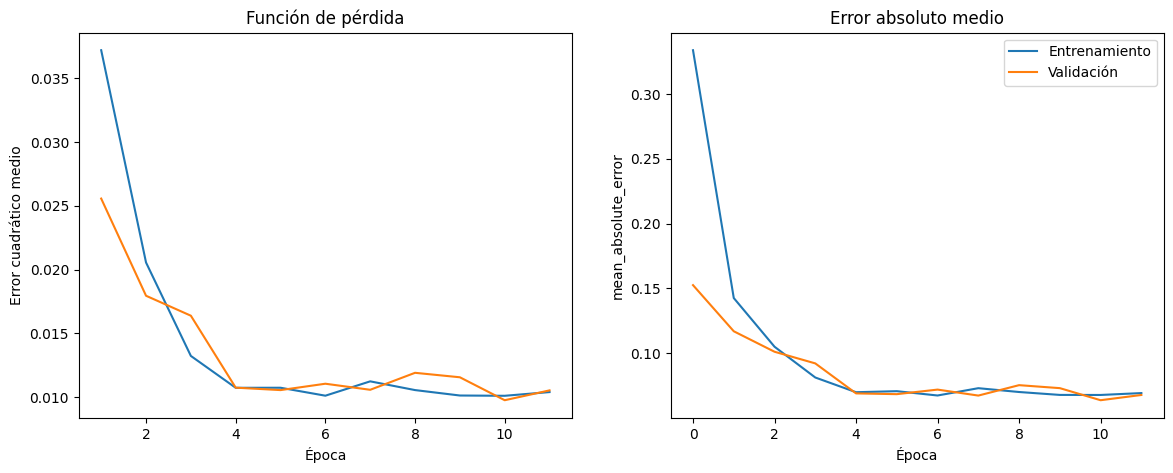

In [14]:
model_base = TimeSeriesModel(
    num_heads=num_heads,
    n_layers=n_layers,
    sequence_length=tau,
    data_dim=data_dim,
    d_model=d_model,
    dim_qkv=dim_qkv,
    dff=dff,
    pred_steps=m,
)

epochs = 12

train_model_and_plot(
    model=model_base.model,
    epochs=epochs,
    adam_optimizer_params={}, 
    X=X_train,
    decoder_input=decoder_input_train,
    y=y_train,
    X_val=X_val,
    decoder_input_val=decoder_input_val,
    y_val=y_val,
)

In [15]:
model_base.model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, None, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 256) │      1,792 │ input_layer[0][0… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, 95, 256)   │  1,381,632 │ dense[0][0]       │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_decoder      │ (None, 95, 256)   │  1,381,632 │ dense[1][0],      │
│ (CustomDecoder)     │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 95, 7)     │      1,792 │ custom_decoder[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,300,546 (31.66 MB)

 Trainable params: 2,766,848 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,533,698 (21.11 MB)

#### Modelo para datos de monedas/activos financieros

Aquí entrenamos el modelo desde cero (*from scratch*) para los nuevos datos.

Epoch 1/12


/Users/miguelruiz/Documents/Academic Stuff/Machine Learning II/AdvancedDL/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_39', 'keras_tensor_40']. Received: the structure of inputs=('*', '*')
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 255ms/step - loss: 1.5602 - mean_absolute_error: 0.6865 - val_loss: 0.0687 - val_mean_absolute_error: 0.2086
Epoch 2/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - loss: 0.0448 - mean_absolute_error: 0.1588 - val_loss: 0.0190 - val_mean_absolute_error: 0.0977
Epoch 3/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - loss: 0.0165 - mean_absolute_error: 0.0881 - val_loss: 0.0124 - val_mean_absolute_error: 0.0733
Epoch 4/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - loss: 0.0132 - mean_absolute_error: 0.0770 - val_loss: 0.0123 - val_mean_absolute_error: 0.0730
Epoch 5/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - loss: 0.0120 - mean_absolute_error: 0.0708 - val_loss: 0.0132 - val_mean_absolute_error: 0.0798
Epoch 6/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - loss: 0.0118 - mean_absolute_error: 0.0685 - val_loss: 0.0107 - val_mean_absolute_error: 0.0642
Epoch 7/12
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - loss: 0.0122 - mean_absolute_error: 0.0702 - val_lo

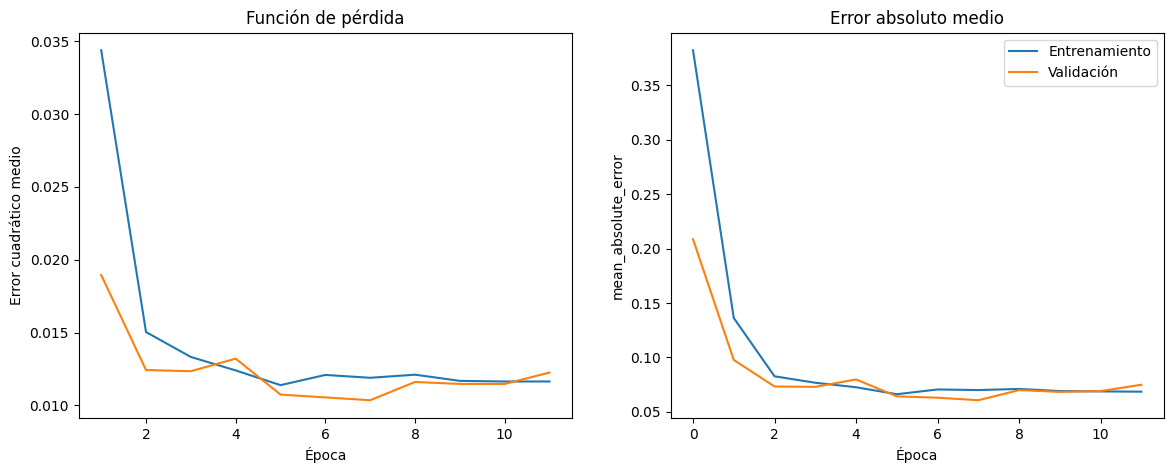

In [16]:
model_scratch = TimeSeriesModel(
    num_heads=num_heads,
    n_layers=n_layers,
    sequence_length=tau,
    data_dim=data_dim,
    d_model=d_model,
    dim_qkv=dim_qkv,
    dff=dff,
    pred_steps=m,
)

epochs = 12

train_model_and_plot(
    model=model_scratch.model,
    epochs=epochs,
    adam_optimizer_params={}, 
    X=X2_train,
    decoder_input=decoder_input2_train,
    y=y2_train,
    X_val=X2_val,
    decoder_input_val=decoder_input2_val,
    y_val=y2_val,
)

### Fine-tunning mediante LORA del modelo entrenado con los datos de criptomonedas para adaptarlo a los datos de monedas/activos financieros.

Utilizaremos rango 1, 2 y 3.

/Users/miguelruiz/Documents/Academic Stuff/Machine Learning II/AdvancedDL/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'feed_forward_18', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/miguelruiz/Documents/Academic Stuff/Machine Learning II/AdvancedDL/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_layer_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/mig

Epoch 1/2


/Users/miguelruiz/Documents/Academic Stuff/Machine Learning II/AdvancedDL/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_117', 'keras_tensor_118']. Received: the structure of inputs=('*', '*')
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 78s 745ms/step - loss: 0.0122 - mean_absolute_error: 0.0675 - val_loss: 0.0102 - val_mean_absolute_error: 0.0587
Epoch 2/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 35s 497ms/step - loss: 0.0108 - mean_absolute_error: 0.0574 - val_loss: 0.0100 - val_mean_absolute_error: 0.0566


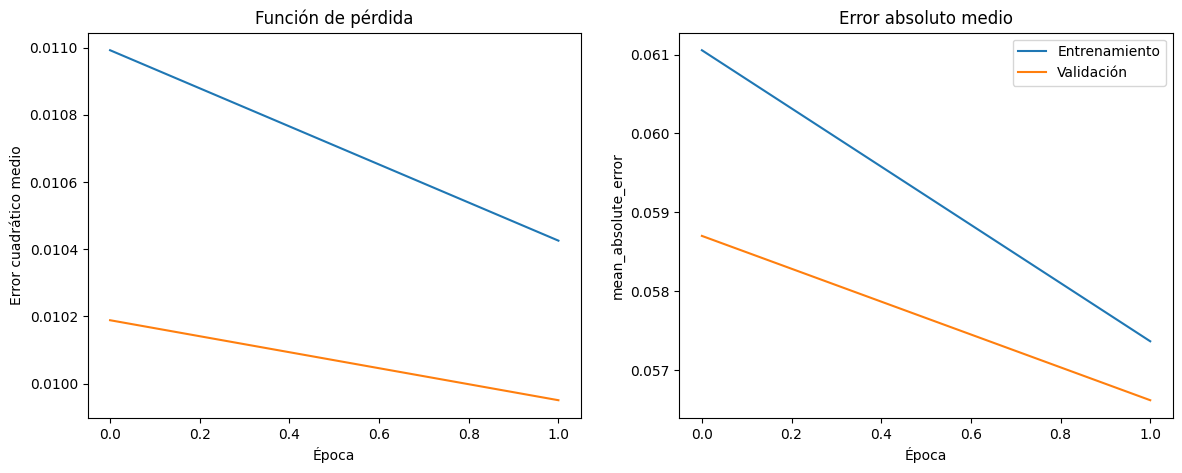

In [17]:
rank = [1, 2, 3]
alpha = 4

lora_model_1 = TimeSeriesModelLora(
    rank=rank[0],
    alpha=alpha,
    ts_model=model_base,
    num_heads=num_heads,
    n_layers=n_layers,
    sequence_length=tau,
    data_dim=data_dim,
    d_model=d_model,
    dim_qkv=dim_qkv,
    dff=dff,
    pred_steps=m,
)

epochs = 2

train_model_and_plot(
    model=lora_model_1.model,
    epochs=epochs,
    adam_optimizer_params={}, 
    X=X2_train,
    decoder_input=decoder_input2_train,
    y=y2_train,
    X_val=X2_val,
    decoder_input_val=decoder_input2_val,
    y_val=y2_val,
    plot_all_loss=True
)

In [18]:
lora_model_1.model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, None, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_24      │ (None, None, 7)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lora_dense          │ (None, None, 256) │      2,312 │ input_layer_24[0… │
│ (LORADense)         │                   │            │ input_layer_25[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 95, 256)   │  1,400,070 │ lora_dense[0][0]  │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_decoder_3    │ (None, 95, 256)   │  1,400,070 │ lora_dense[1][0], │
│ (CustomDecoder)     │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lora_dense_1        │ (None, 95, 7)     │      2,063 │ custom_decoder_3… │
│ (LORADense)         │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,879,851 (10.99 MB)

 Trainable params: 37,667 (147.14 KB)

 Non-trainable params: 2,766,848 (10.55 MB)

 Optimizer params: 75,336 (294.29 KB)

/Users/miguelruiz/Documents/Academic Stuff/Machine Learning II/AdvancedDL/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'feed_forward_30', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/miguelruiz/Documents/Academic Stuff/Machine Learning II/AdvancedDL/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_layer_15', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/mi

Epoch 1/2


/Users/miguelruiz/Documents/Academic Stuff/Machine Learning II/AdvancedDL/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_239', 'keras_tensor_240']. Received: the structure of inputs=('*', '*')
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 89s 886ms/step - loss: 0.0114 - mean_absolute_error: 0.0627 - val_loss: 0.0102 - val_mean_absolute_error: 0.0589
Epoch 2/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 578ms/step - loss: 0.0109 - mean_absolute_error: 0.0575 - val_loss: 0.0102 - val_mean_absolute_error: 0.0590


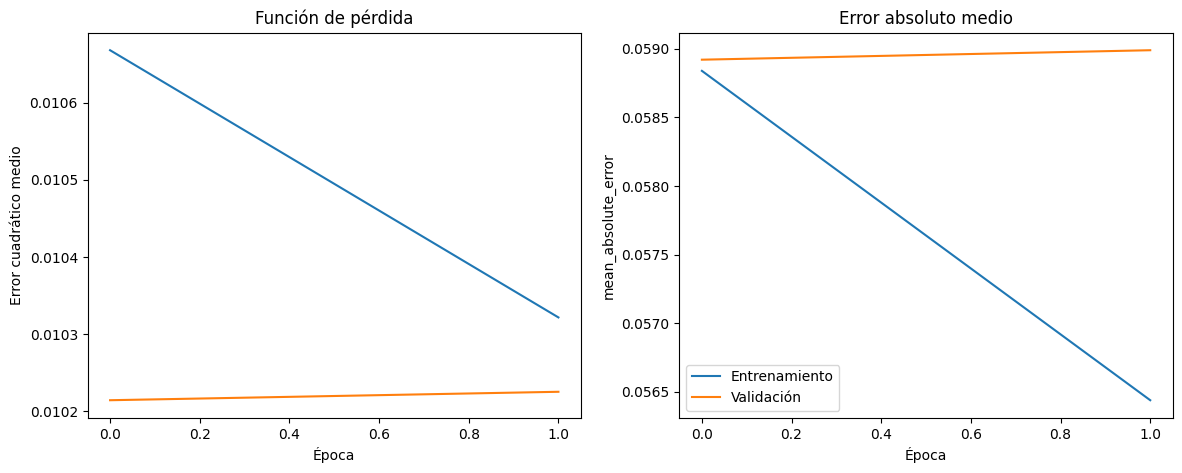

In [19]:
lora_model_2 = TimeSeriesModelLora(
    rank=rank[1],
    alpha=alpha,
    ts_model=model_base,
    num_heads=num_heads,
    n_layers=n_layers,
    sequence_length=tau,
    data_dim=data_dim,
    d_model=d_model,
    dim_qkv=dim_qkv,
    dff=dff,
    pred_steps=m,
)

epochs = 2

train_model_and_plot(
    model=lora_model_2.model,
    epochs=epochs,
    adam_optimizer_params={}, 
    X=X2_train,
    decoder_input=decoder_input2_train,
    y=y2_train,
    X_val=X2_val,
    decoder_input_val=decoder_input2_val,
    y_val=y2_val,
    plot_all_loss=True
)

/Users/miguelruiz/Documents/Academic Stuff/Machine Learning II/AdvancedDL/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'feed_forward_42', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/miguelruiz/Documents/Academic Stuff/Machine Learning II/AdvancedDL/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_layer_21', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/mi

Epoch 1/2


/Users/miguelruiz/Documents/Academic Stuff/Machine Learning II/AdvancedDL/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_361', 'keras_tensor_362']. Received: the structure of inputs=('*', '*')
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - loss: 0.0110 - mean_absolute_error: 0.0614 - val_loss: 0.0101 - val_mean_absolute_error: 0.0578
Epoch 2/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 43s 625ms/step - loss: 0.0103 - mean_absolute_error: 0.0564 - val_loss: 0.0100 - val_mean_absolute_error: 0.0572


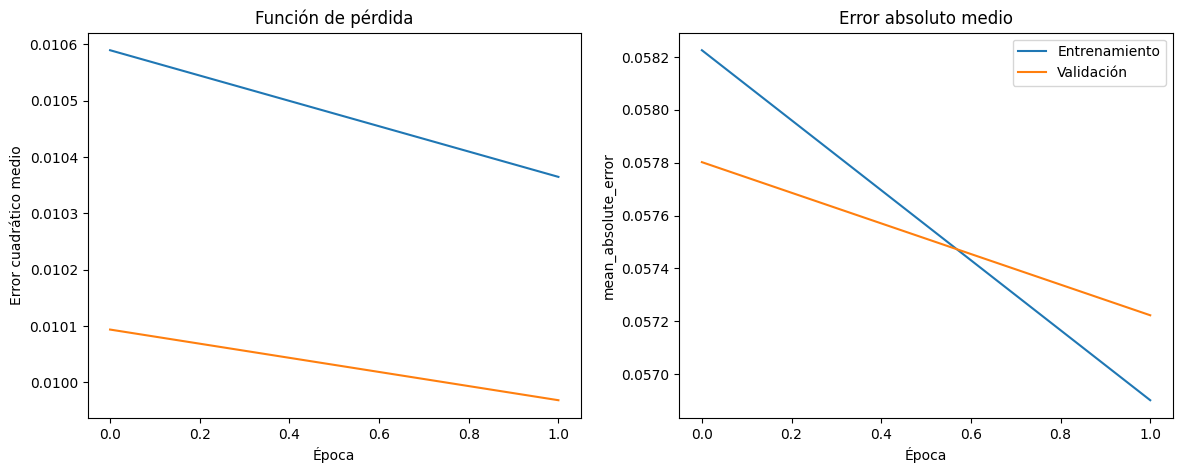

In [20]:
lora_model_3 = TimeSeriesModelLora(
    rank=rank[2],
    alpha=alpha,
    ts_model=model_base,
    num_heads=num_heads,
    n_layers=n_layers,
    sequence_length=tau,
    data_dim=data_dim,
    d_model=d_model,
    dim_qkv=dim_qkv,
    dff=dff,
    pred_steps=m,
)

epochs = 2

train_model_and_plot(
    model=lora_model_3.model,
    epochs=epochs,
    adam_optimizer_params={}, 
    X=X2_train,
    decoder_input=decoder_input2_train,
    y=y2_train,
    X_val=X2_val,
    decoder_input_val=decoder_input2_val,
    y_val=y2_val,
    plot_all_loss=True
)

### Full-tuning del modelo preentrenado para los nuevos datos

Epoch 1/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 72s 602ms/step - loss: 0.5729 - mean_absolute_error: 0.4698 - val_loss: 0.0402 - val_mean_absolute_error: 0.1584
Epoch 2/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - loss: 0.0209 - mean_absolute_error: 0.1007 - val_loss: 0.0119 - val_mean_absolute_error: 0.0707


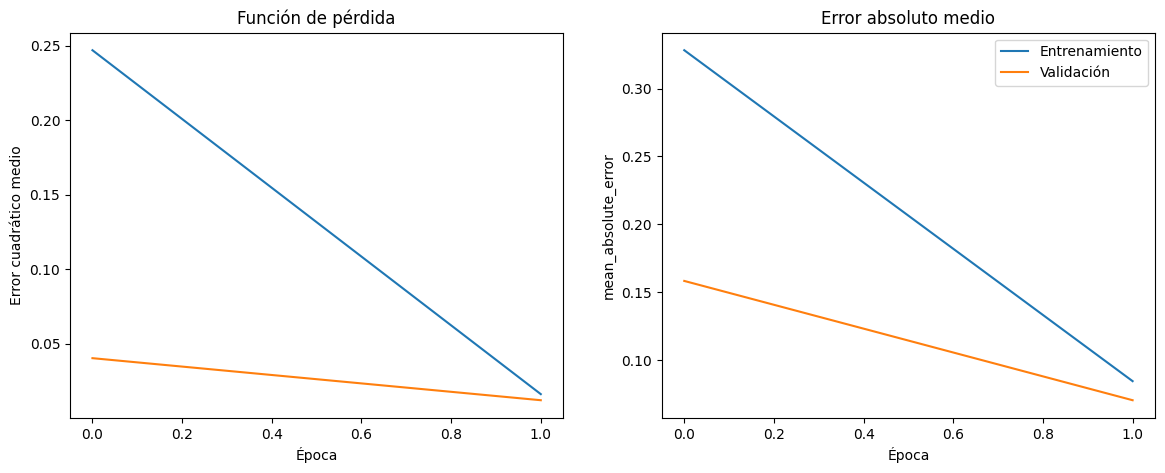

In [21]:
epochs = 2

model_base.model.trainable = True

train_model_and_plot(
    model=model_base.model,
    epochs=epochs,
    adam_optimizer_params={}, 
    X=X2_train,
    decoder_input=decoder_input2_train,
    y=y2_train,
    X_val=X2_val,
    decoder_input_val=decoder_input2_val,
    y_val=y2_val,
    plot_all_loss=True
)

## Inferencia

Por cada modelo, vamos a predecir con el conjunto de prueba y obtener el error absoluto medio obtenido en cada serie de tiempo en la escala de los datos preprocesados y en la escala de los precios. La predicciones se verán gráficamente escogiendo aleatoriamente 4 tiempos $t$ para visualizar la secuencia real y la secuencia predicha por cada activo financiero, en una vecindad de dichos tiempos. 

Para tener una referencia, vamos a comparar los modelos con la predicción que consiste en mantener el último valor de la secuencia input constante en la secuencia de predicción, es decir, dada la secuencia $(x_t, x_{t+1}, ..., x_{t+\tau-1})$ como input predecir la secuencia $(x_{t+\tau-1}, ..., x_{t+\tau-1})$ de tamaño $m$.

Las funciones auxiliares para reproducir las siguientes gráficas y hacer el análisis de los errores se encuentran en ``utils.py``.

### Predicción

Predicciones del modelo entrenado desde cero con los nuevos datos (baseline).

52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step

Errores absolutos medios en la escala normalizada:
EUR : 0.14198414298402387
JPY : 0.19454922626572044
GBP : 0.16645486810695237
MXN : 0.1075870698167127
CHF : 0.21379262955879724
Oil : 0.1559790265540625
Gold : 0.18907431827790888

Errores absolutos medios en la escala de los precios:
EUR : 0.0014494483937897984
JPY : 1.644994907968463e-05
GBP : 0.0021846563341498424
MXN : 8.271569298594838e-05
CHF : 0.0023371437788468367
Oil : 0.577032441069102
Gold : 7.036744447279255


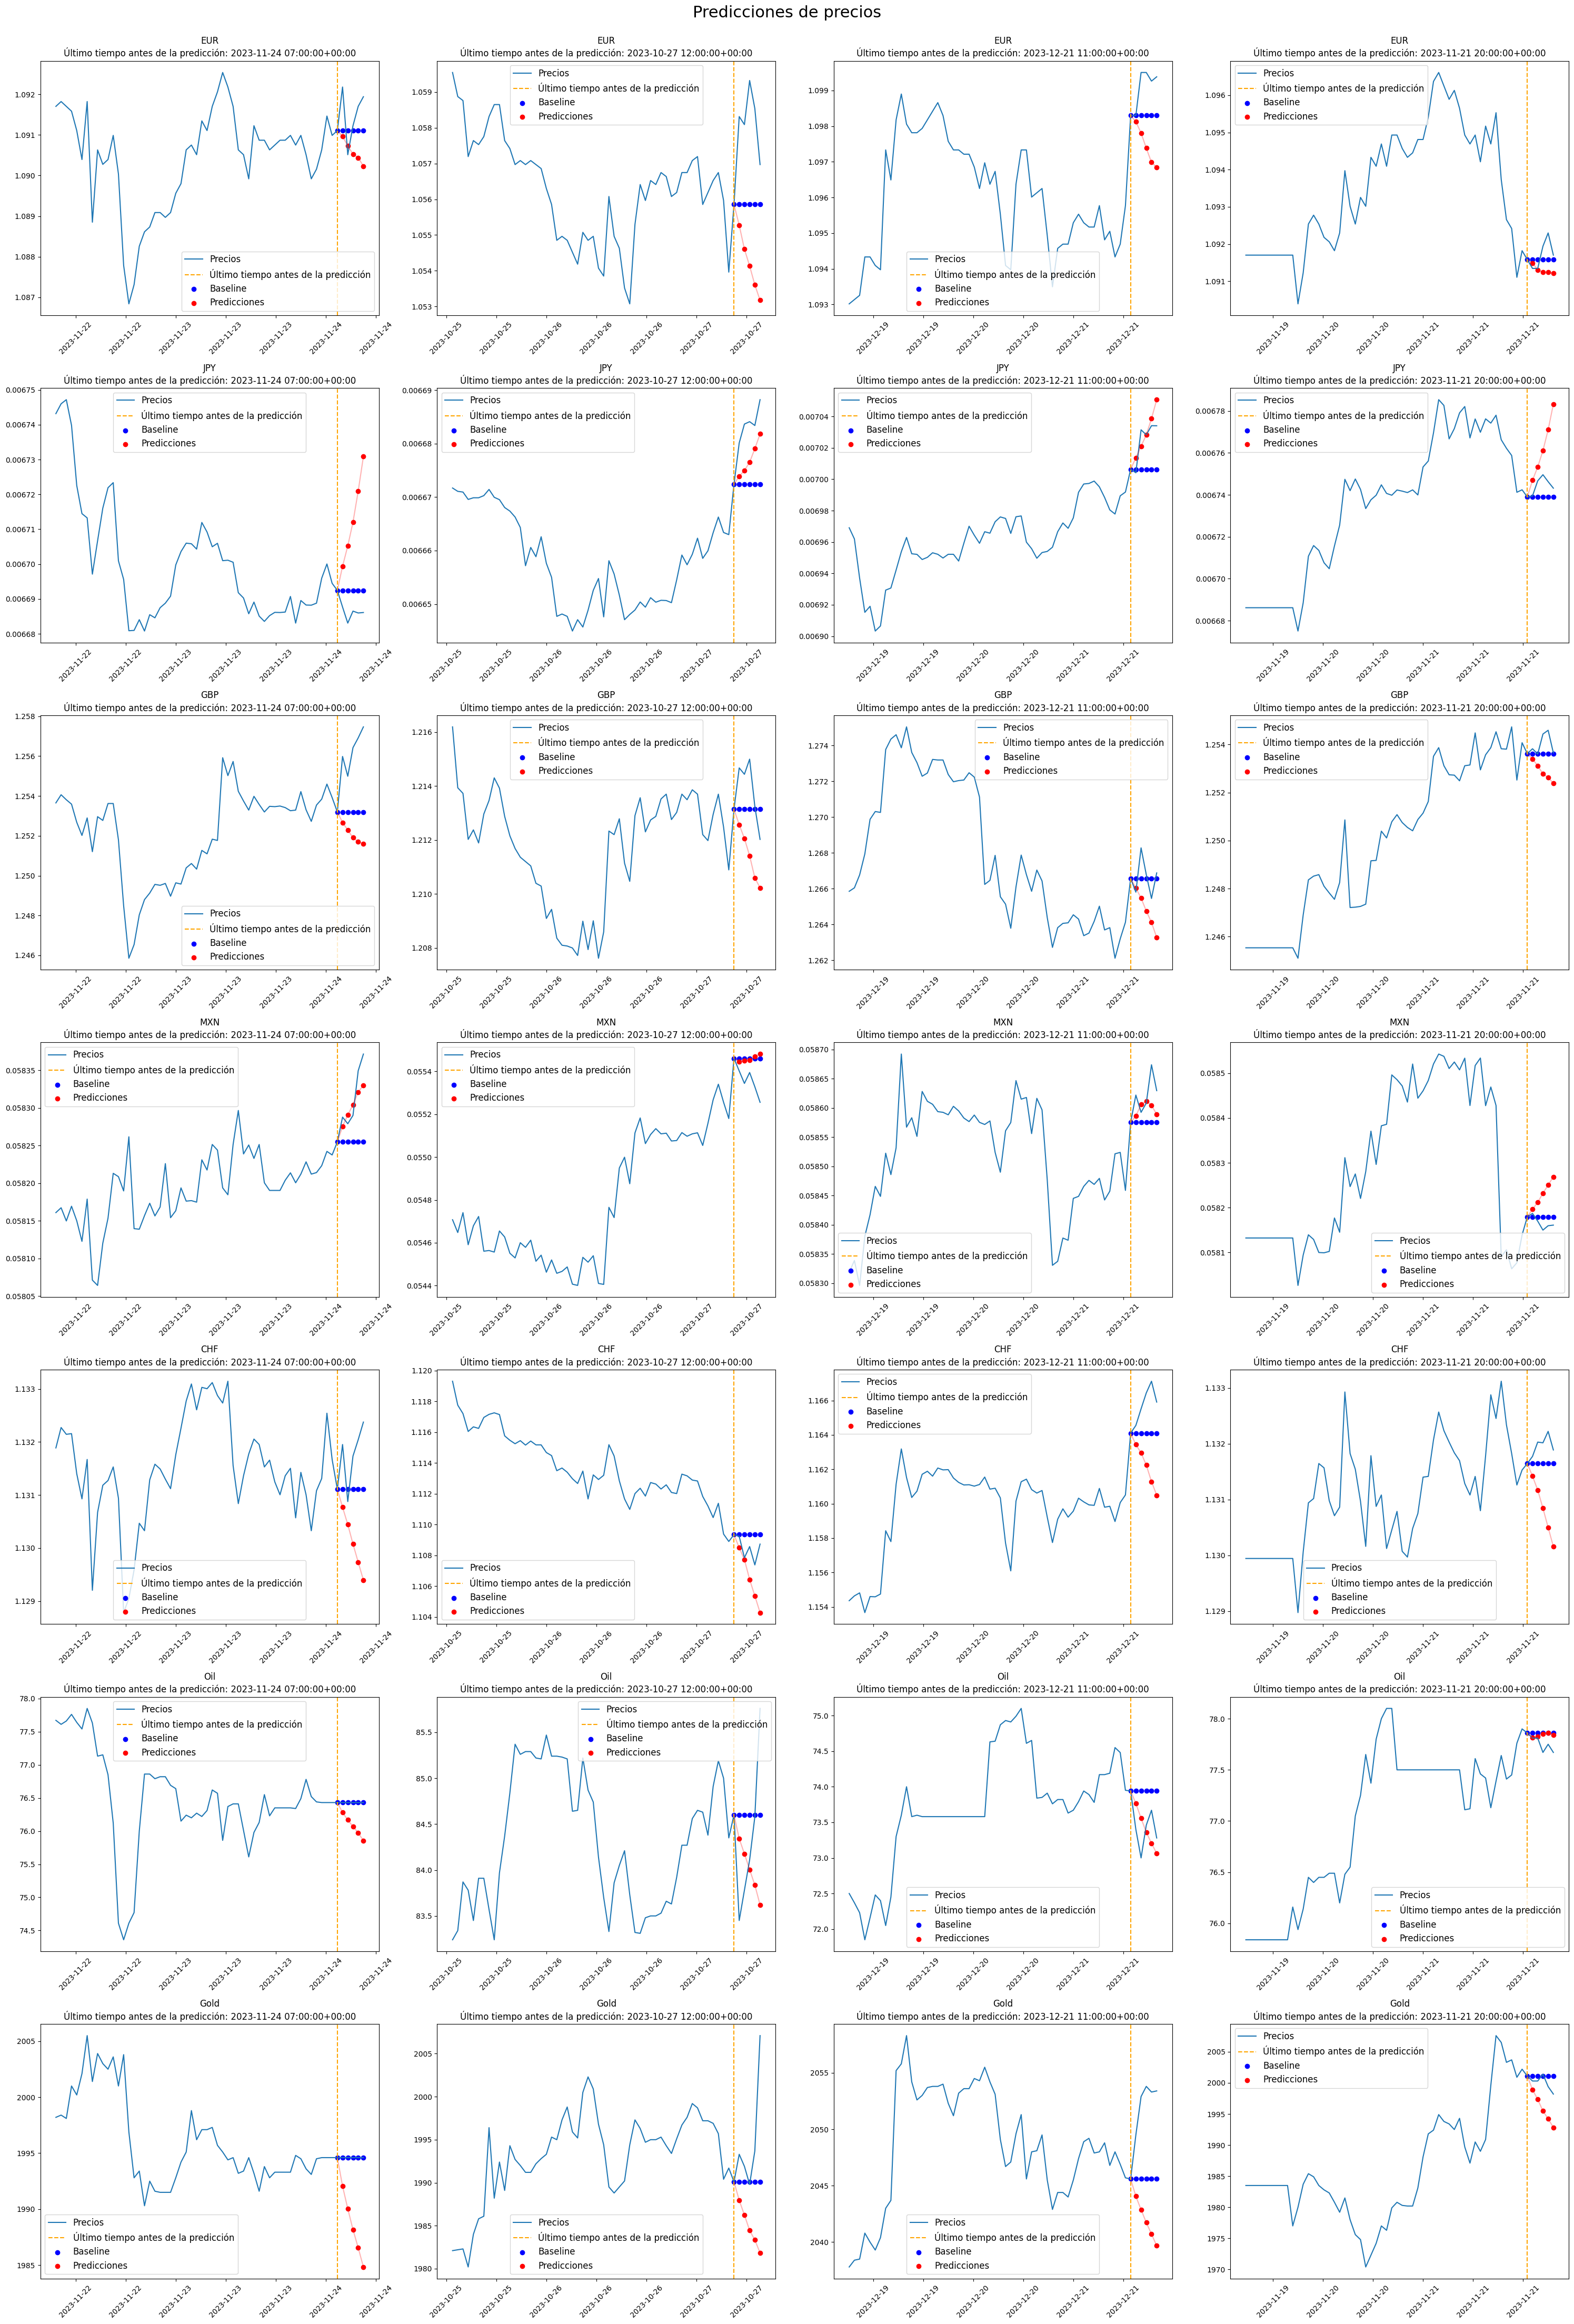

In [22]:
np.random.seed(13)
rand_ind = np.random.choice(n_test_new - T, size=4, replace=False)

pred_baseline, pred_raw_baseline, mae_baseline, mae_raw_baseline = predictions_analysis(
    model=model_scratch,
    X_test=X2_test,
    y_test=y2_test,
    y_test_raw=y2_test_raw,
    back2rawdata=lambda data: minmax_scaler2_test.inverse_transform(data),
    dataset_df=currencies_df,
    T=T,
    m=m,
    rand_ind=rand_ind,
    rand_times=[index2timestamp(ind, "test", time_index_assets, n_train_new, n_test_new) for ind in rand_ind],
    window_size=60
)

Predicciones del modelo preentrenado con LORA fine-tuning, con r = 1

52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step

Errores absolutos medios en la escala normalizada:
EUR : 0.10075997241110043
JPY : 0.10301525103475391
GBP : 0.10438272556365935
MXN : 0.10267659454224035
CHF : 0.11135040687030048
Oil : 0.09919321576668348
Gold : 0.10044008252415101

Errores absolutos medios en la escala de los precios:
EUR : 0.0009607831464000578
JPY : 7.69499796056957e-06
GBP : 0.0012555548948946734
MXN : 7.842261022834144e-05
CHF : 0.0010947399934476362
Oil : 0.33241431168144897
Gold : 3.6488586736302646


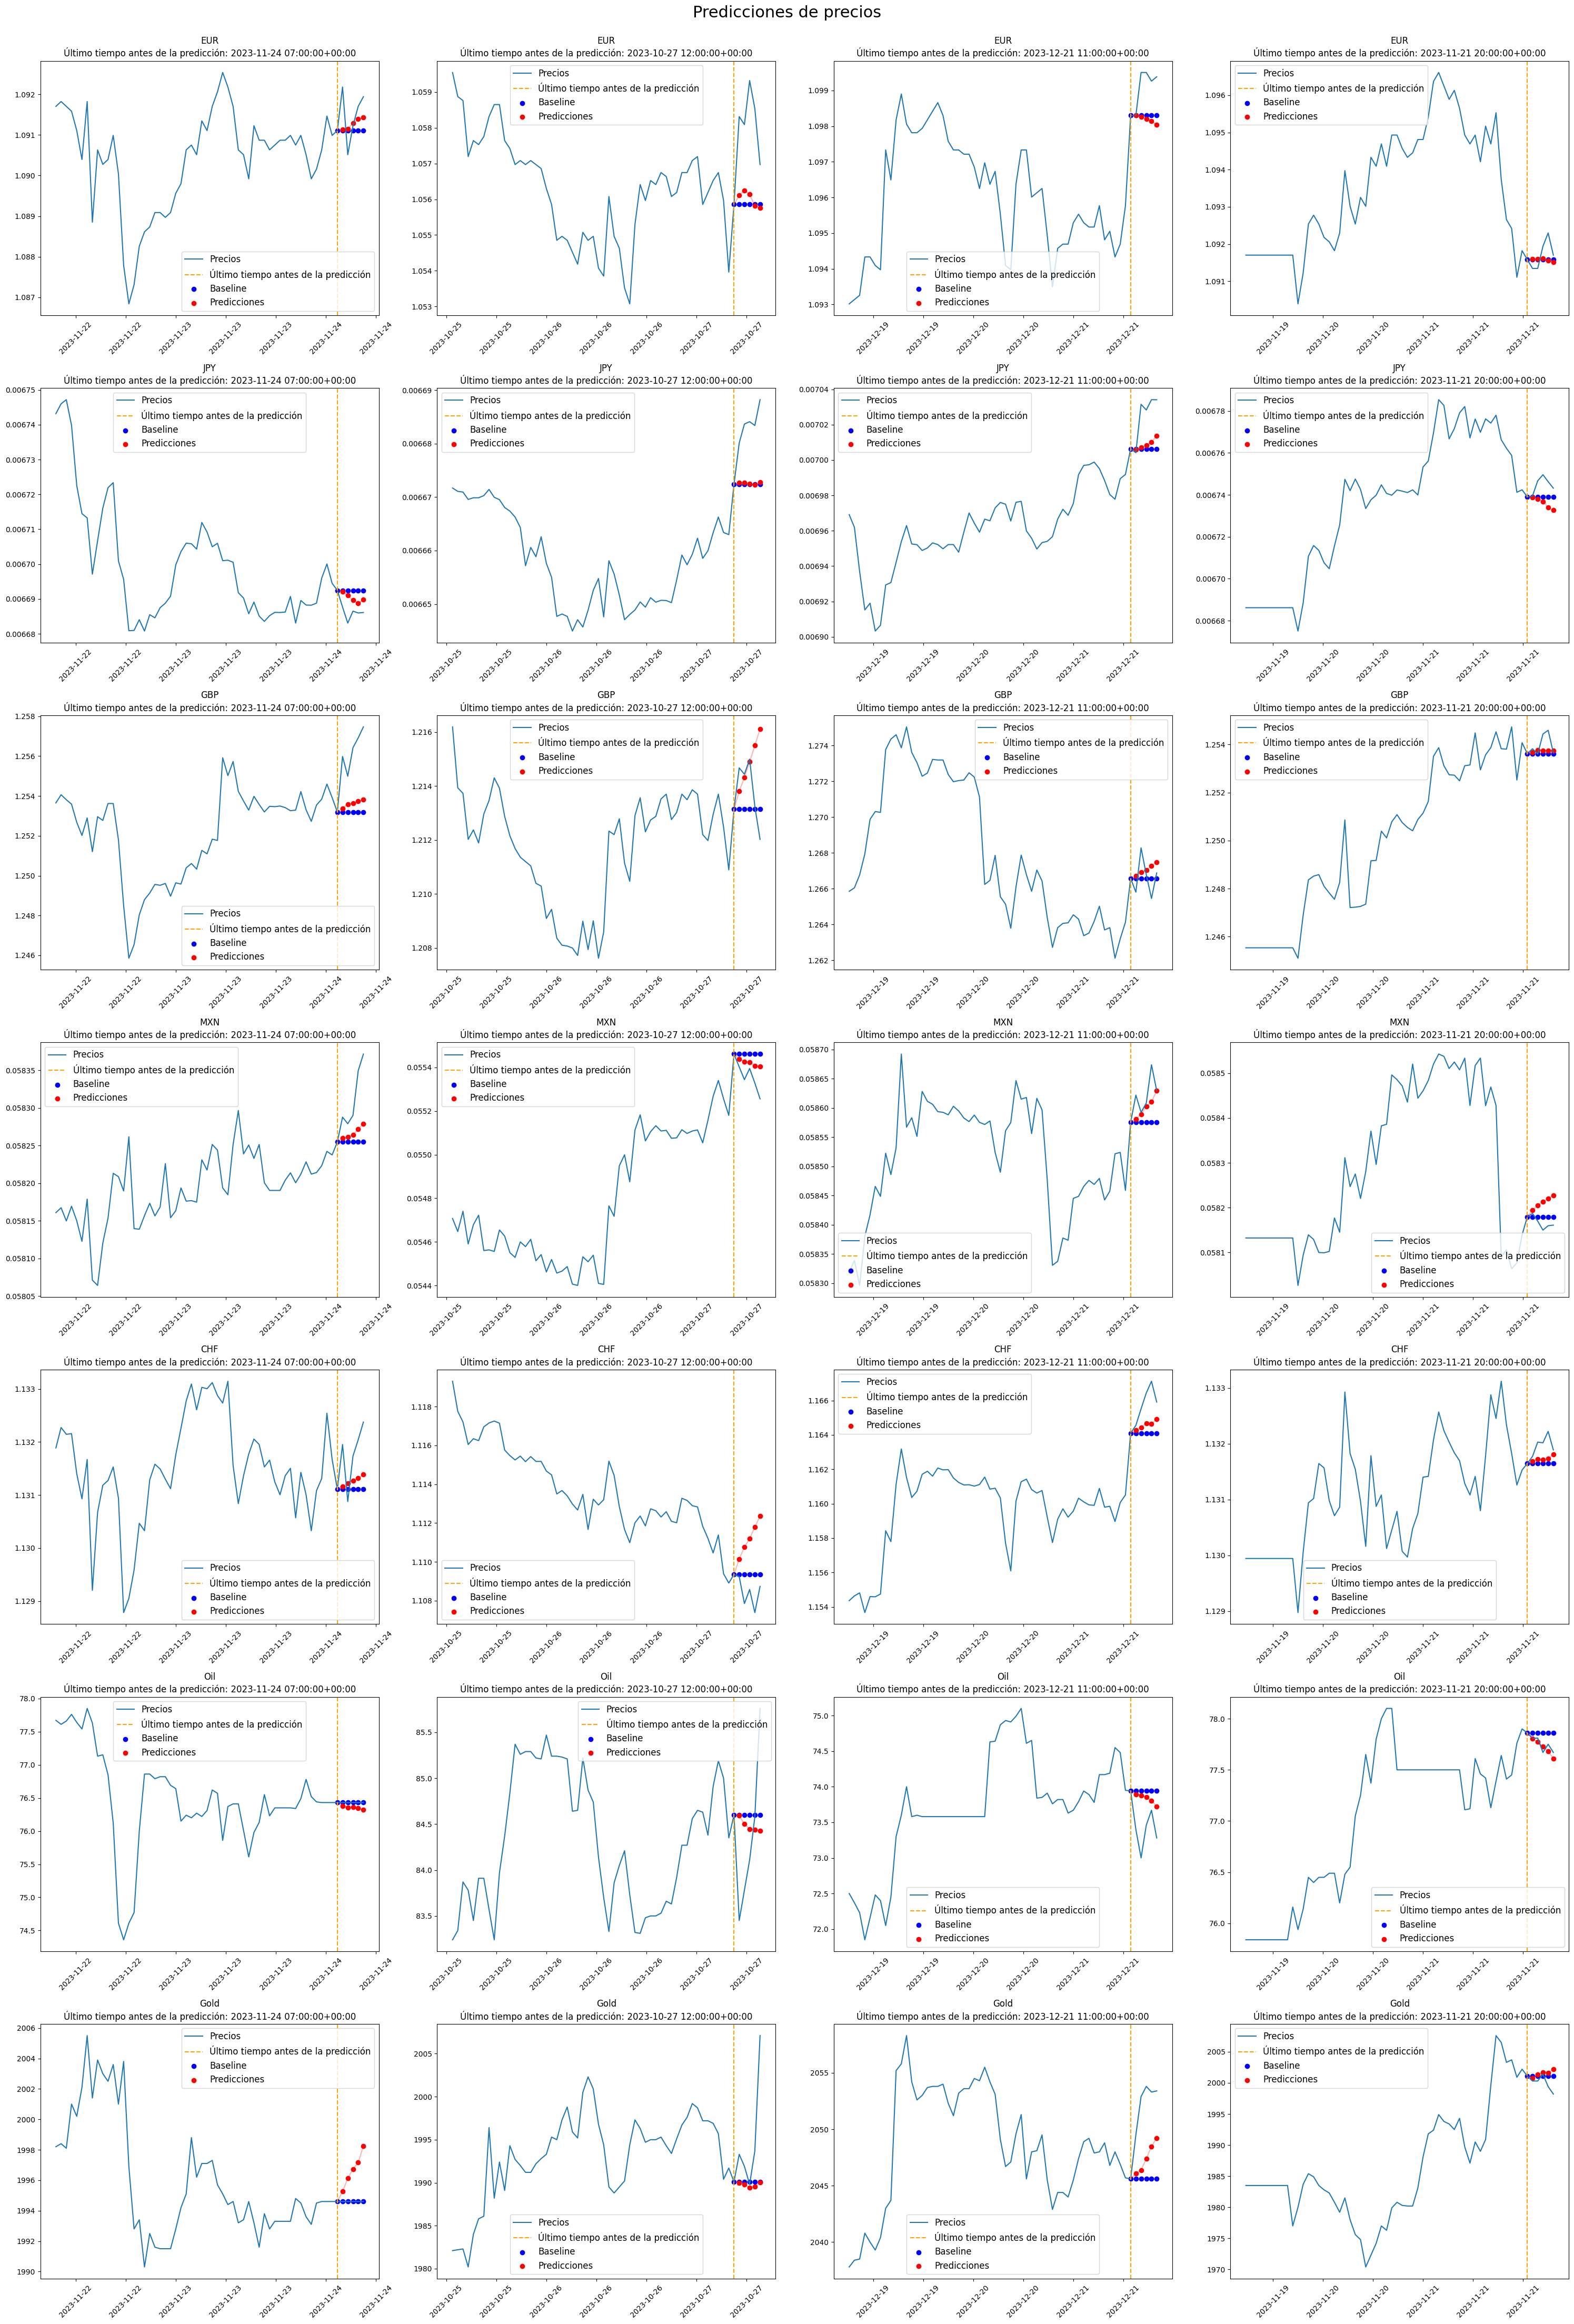

In [23]:
np.random.seed(13)
rand_ind = np.random.choice(n_test_new - T, size=4, replace=False)

pred_lora1, pred_raw_lora1, mae_lora1, mae_raw_lora1 = predictions_analysis(
    model=lora_model_1,
    X_test=X2_test,
    y_test=y2_test,
    y_test_raw=y2_test_raw,
    back2rawdata=lambda data: minmax_scaler2_test.inverse_transform(data),
    dataset_df=currencies_df,
    T=T,
    m=m,
    rand_ind=rand_ind,
    rand_times=[index2timestamp(ind, "test", time_index_assets, n_train_new, n_test_new) for ind in rand_ind],
    window_size=60
)

Predicciones del modelo preentrenado con LORA fine-tuning, con r = 2

52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step

Errores absolutos medios en la escala normalizada:
EUR : 0.10747094326642274
JPY : 0.10887394219646618
GBP : 0.11092290431625852
MXN : 0.11776959748141115
CHF : 0.11663575563067431
Oil : 0.10960247818086243
Gold : 0.12076484741911404

Errores absolutos medios en la escala de los precios:
EUR : 0.0010435347984672143
JPY : 8.200820704461208e-06
GBP : 0.0013600200460476095
MXN : 9.281259267367306e-05
CHF : 0.0011558579616362972
Oil : 0.37226079274621704
Gold : 4.619361472935746


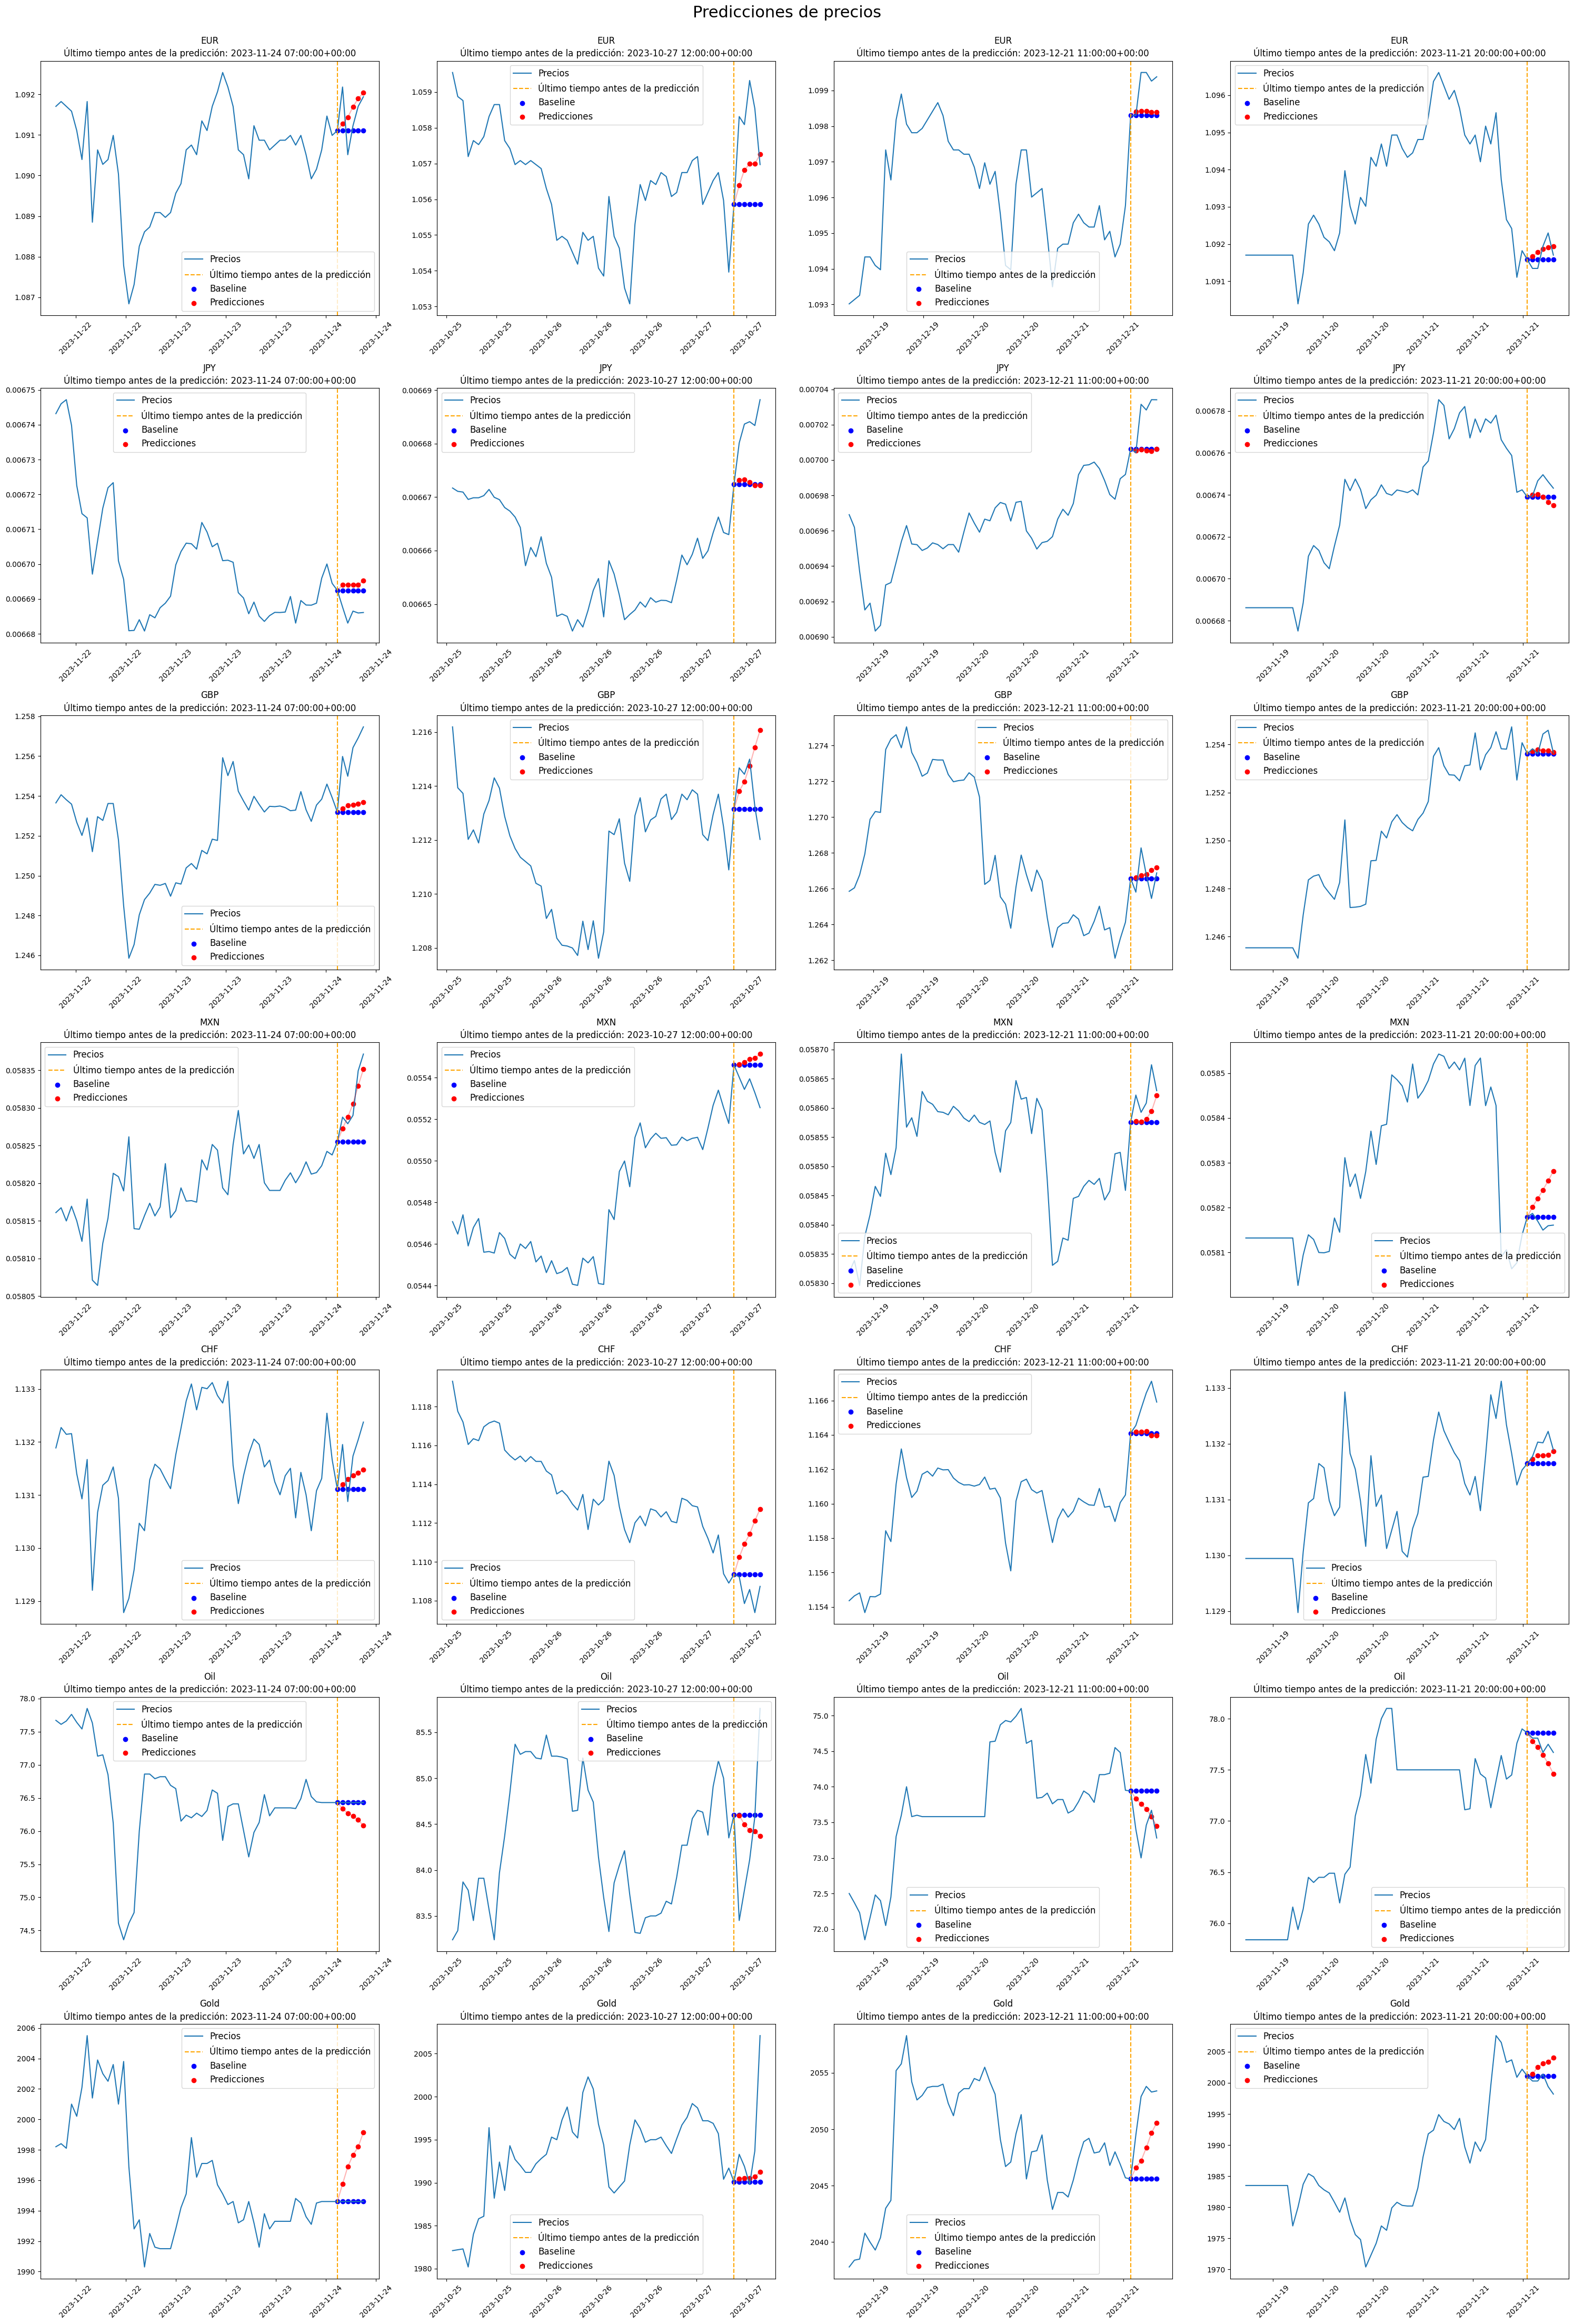

In [24]:
np.random.seed(13)
rand_ind = np.random.choice(n_test_new - T, size=4, replace=False)

pred_lora2, pred_raw_lora2, mae_lora2, mae_raw_lora2 = predictions_analysis(
    model=lora_model_2,
    X_test=X2_test,
    y_test=y2_test,
    y_test_raw=y2_test_raw,
    back2rawdata=lambda data: minmax_scaler2_test.inverse_transform(data),
    dataset_df=currencies_df,
    T=T,
    m=m,
    rand_ind=rand_ind,
    rand_times=[index2timestamp(ind, "test", time_index_assets, n_train_new, n_test_new) for ind in rand_ind],
    window_size=60
)

Predicciones del modelo preentrenado con LORA fine-tuning, con r = 3

52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 650ms/step

Errores absolutos medios en la escala normalizada:
EUR : 0.10156607122175504
JPY : 0.10938413901087295
GBP : 0.10003224531197469
MXN : 0.10113288267547063
CHF : 0.12123818358872435
Oil : 0.09195919454833967
Gold : 0.11338405523209785

Errores absolutos medios en la escala de los precios:
EUR : 0.0009677576073119294
JPY : 8.398841289559447e-06
GBP : 0.0011976853199183405
MXN : 7.619660226316451e-05
CHF : 0.0012101379997916722
Oil : 0.3080140050912785
Gold : 4.152648955242372


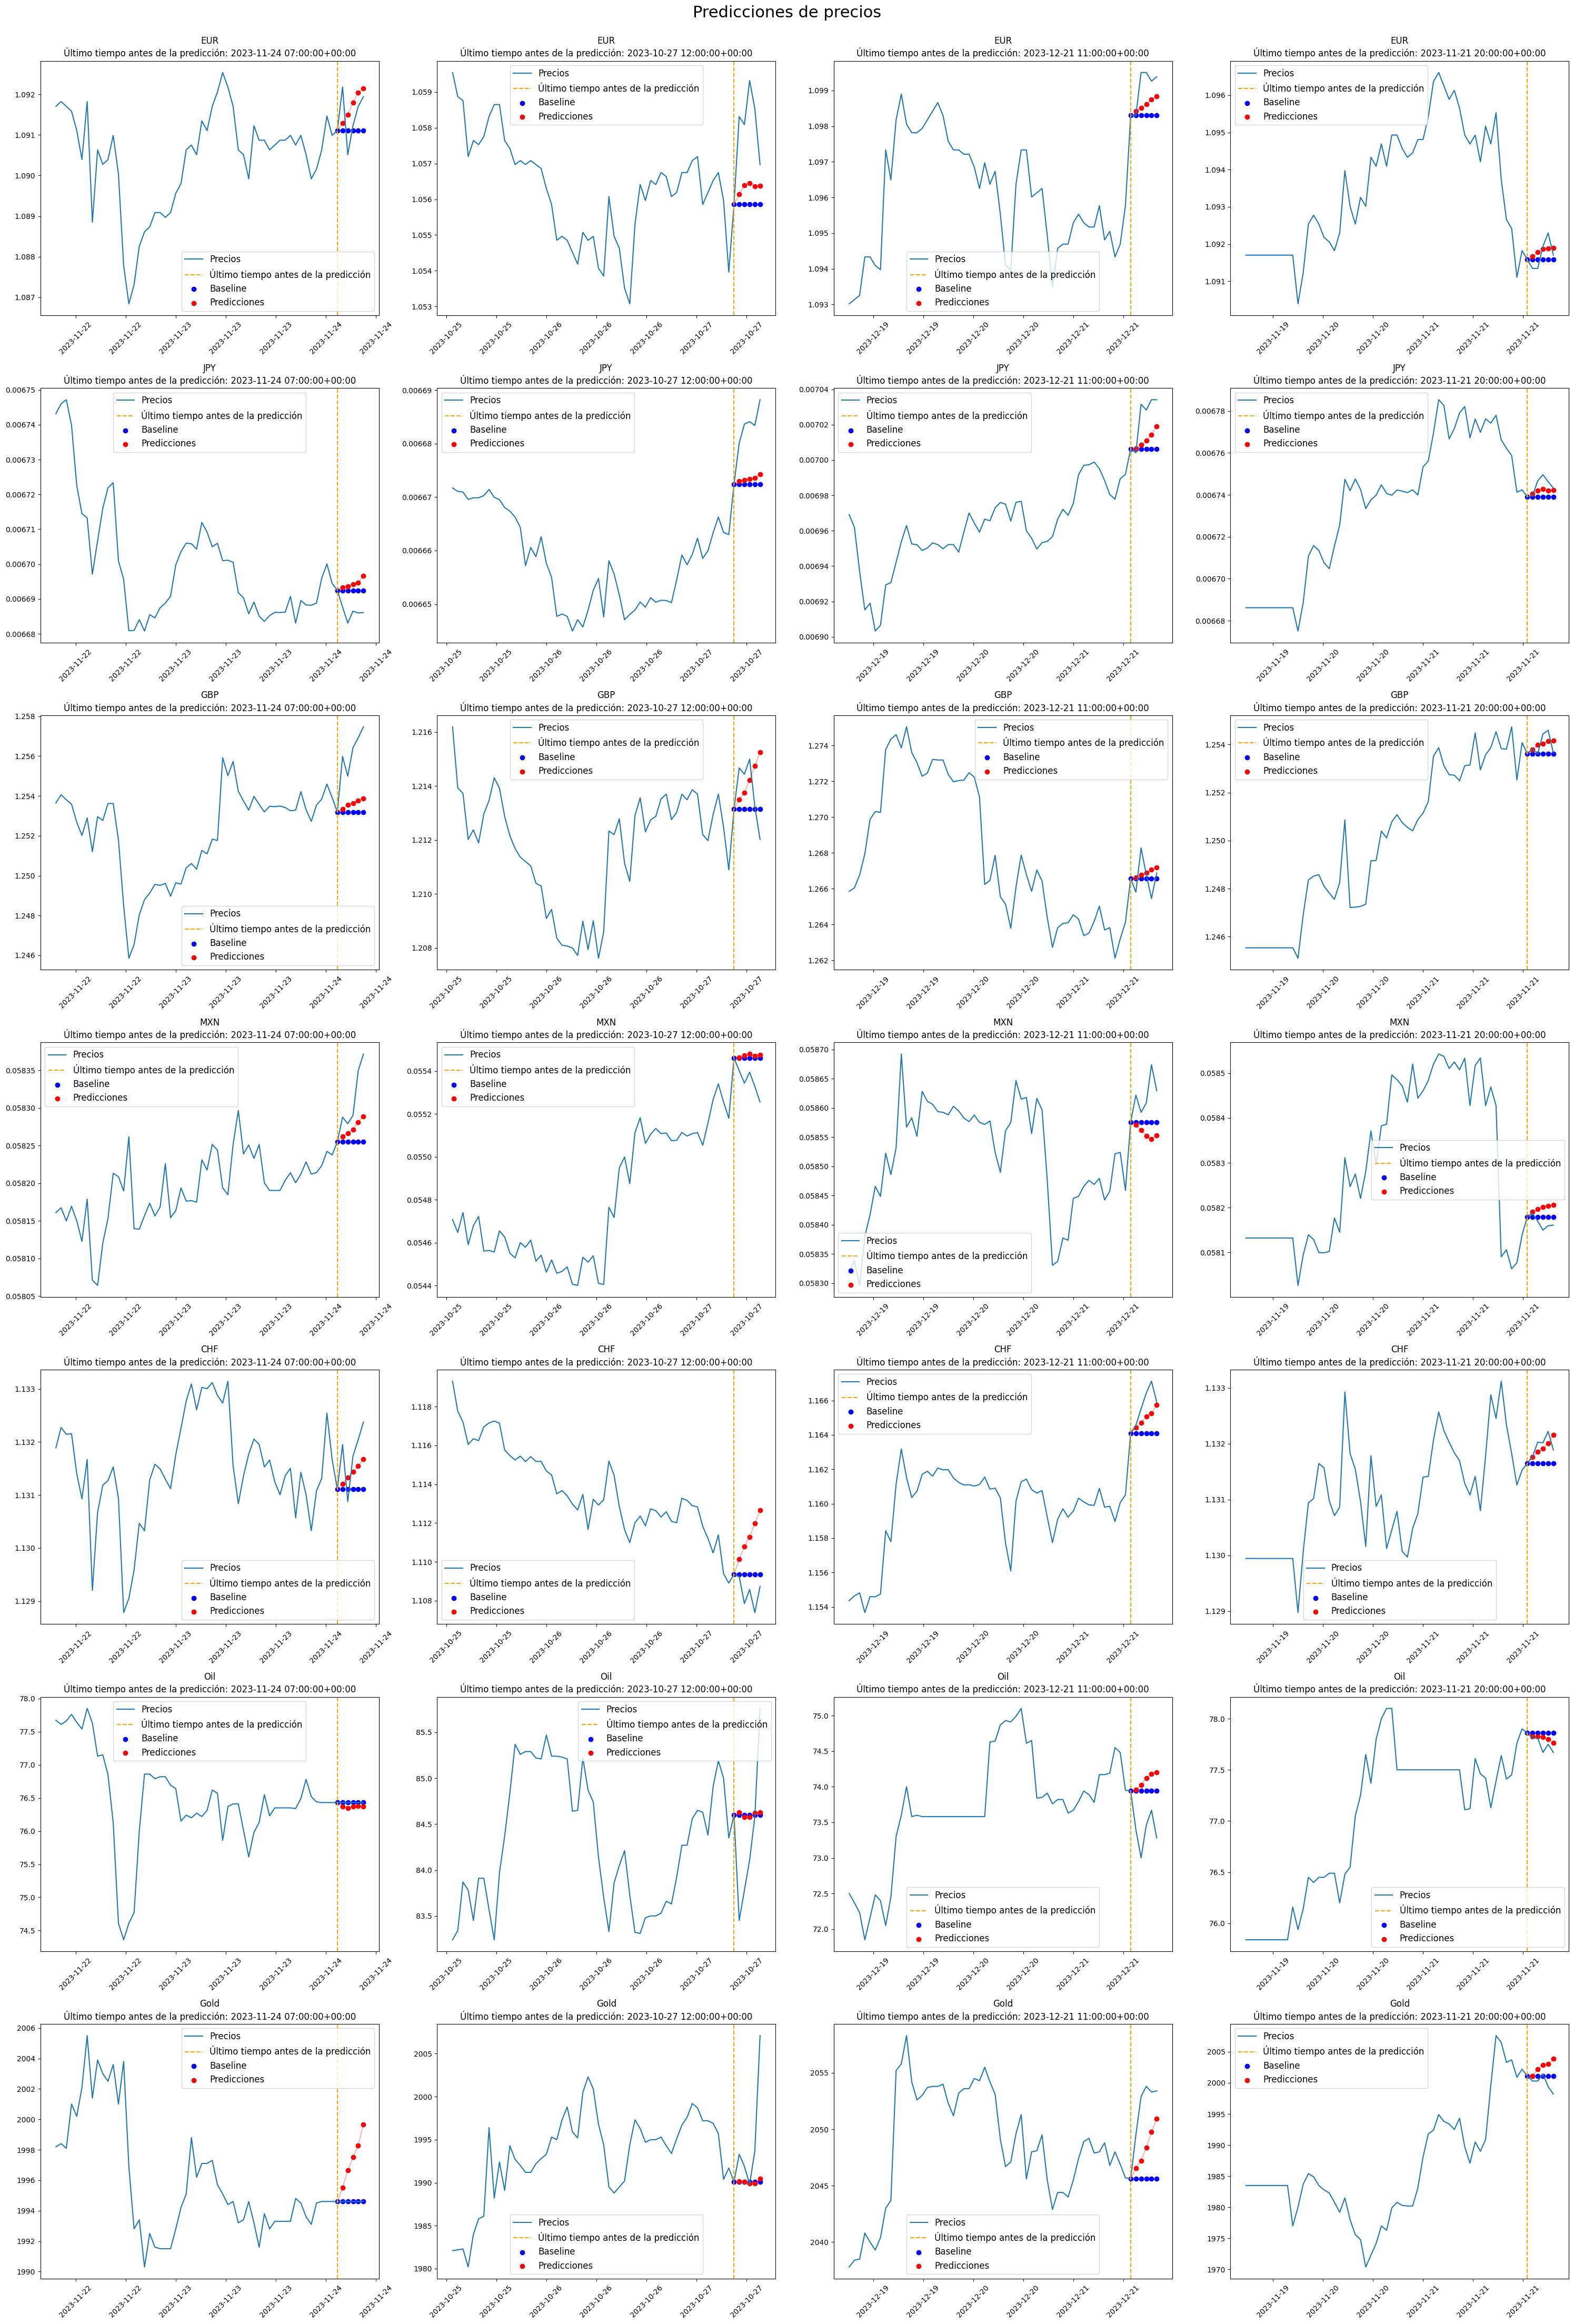

In [25]:
np.random.seed(13)
rand_ind = np.random.choice(n_test_new - T, size=4, replace=False)

pred_lora3, pred_raw_lora3, mae_lora3, mae_raw_lora3 = predictions_analysis(
    model=lora_model_3,
    X_test=X2_test,
    y_test=y2_test,
    y_test_raw=y2_test_raw,
    back2rawdata=lambda data: minmax_scaler2_test.inverse_transform(data),
    dataset_df=currencies_df,
    T=T,
    m=m,
    rand_ind=rand_ind,
    rand_times=[index2timestamp(ind, "test", time_index_assets, n_train_new, n_test_new) for ind in rand_ind],
    window_size=60
)

Predicciones del modelo preentrenado con full-tuning

52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step

Errores absolutos medios en la escala normalizada:
EUR : 0.15523971689450586
JPY : 0.1183495640843052
GBP : 0.1660754455851404
MXN : 0.13142105834319265
CHF : 0.16658599571463995
Oil : 0.10013358647865232
Gold : 0.13951992500586696

Errores absolutos medios en la escala de los precios:
EUR : 0.001601610326537518
JPY : 8.948046335268875e-06
GBP : 0.0021870657173105428
MXN : 0.0001089717985247995
CHF : 0.0018653969392452975
Oil : 0.3323616289288839
Gold : 5.436613644262037


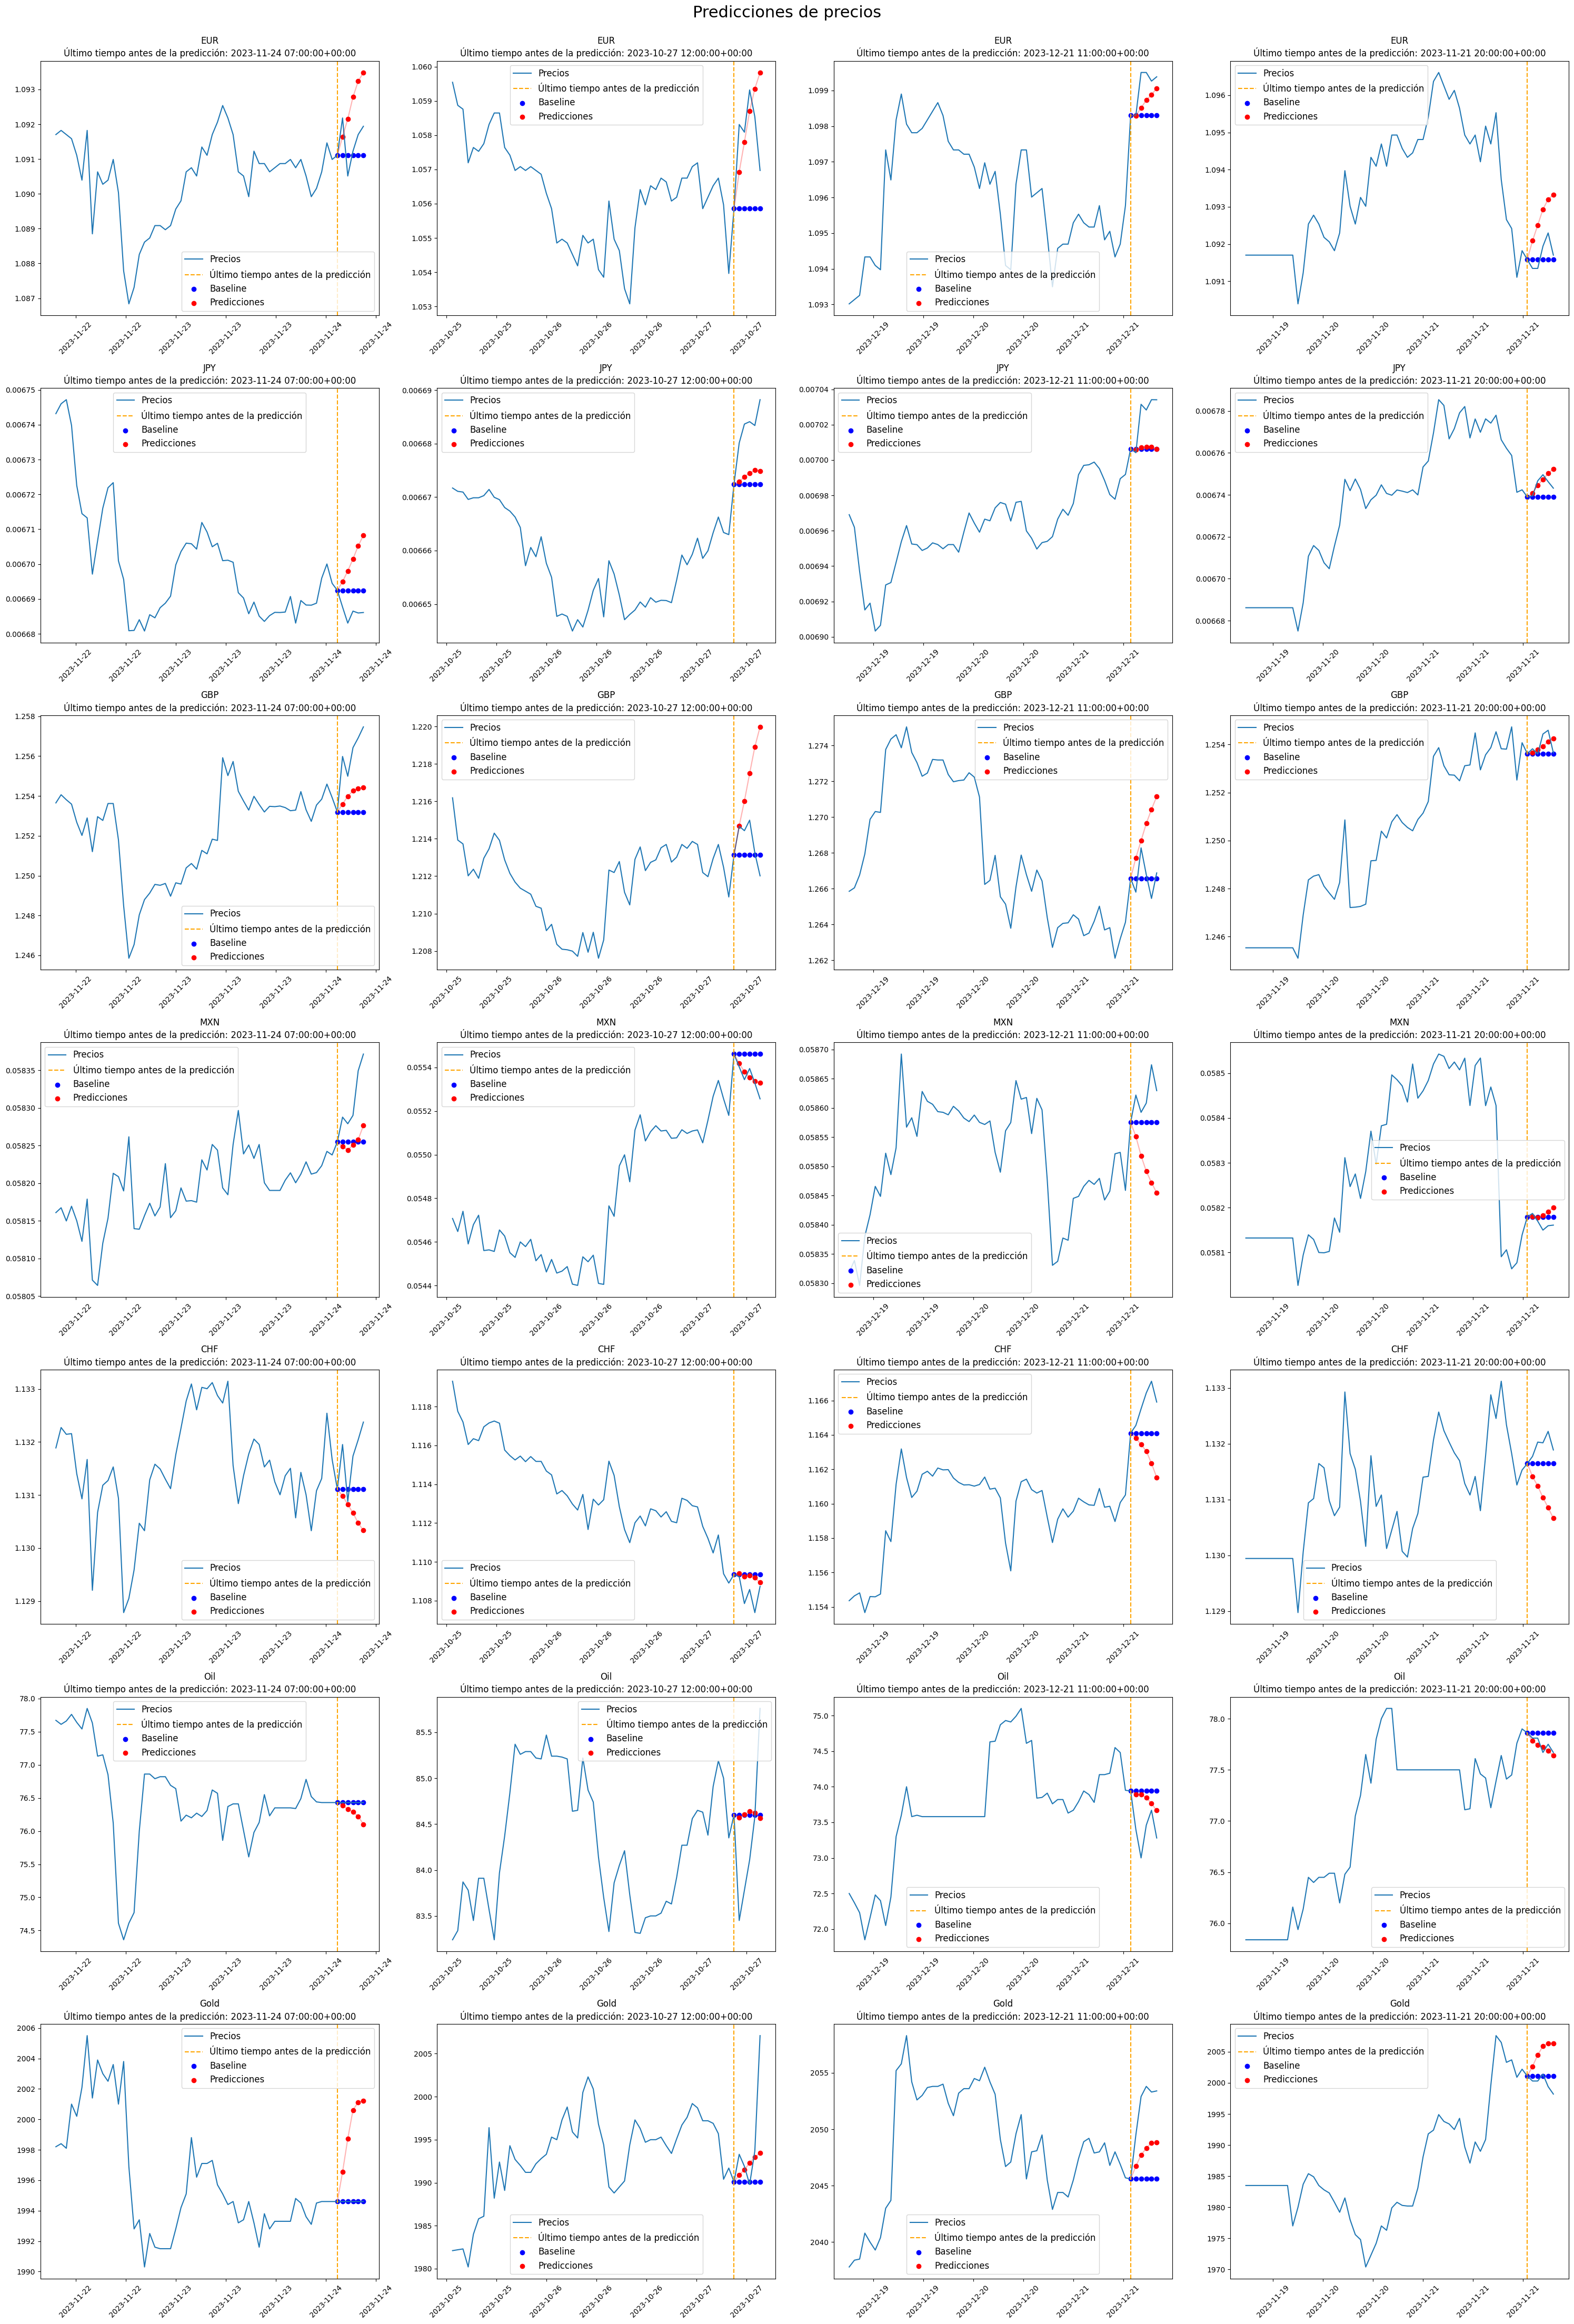

In [26]:
np.random.seed(13)
rand_ind = np.random.choice(n_test_new - T, size=4, replace=False)

pred_full, pred_raw_full, mae_full, mae_raw_full = predictions_analysis(
    model=model_base,
    X_test=X2_test,
    y_test=y2_test,
    y_test_raw=y2_test_raw,
    back2rawdata=lambda data: minmax_scaler2_test.inverse_transform(data),
    dataset_df=currencies_df,
    T=T,
    m=m,
    rand_ind=rand_ind,
    rand_times=[index2timestamp(ind, "test", time_index_assets, n_train_new, n_test_new) for ind in rand_ind],
    window_size=60
)

## Resultados y conclusiones

A continuación se muestran los errores absolutos medios (*MAE*) relativos de cada modelo:
- *baseline*, modelo entrenado desce 0 con los datos
- full-tuning del model preentrenado
- fine-tuning del modelo preentrenado usando LORA con r=1
- fine-tuning del modelo preentrenado usando LORA con r=2
- fine-tuning del modelo preentrenado usando LORA con r=2

Los errores relativos significan que se normalizan con respecto a los errores del baseline.

In [27]:
modelos = [
    "Baseline",
    "Full-tuning",
    "LORA r=1",
    "LORA r=2",
    "LORA r=3",
]
assets = currencies_df.columns.tolist()
errores = [mae_raw_baseline, mae_raw_full, mae_raw_lora1, mae_raw_lora2, mae_raw_lora3]

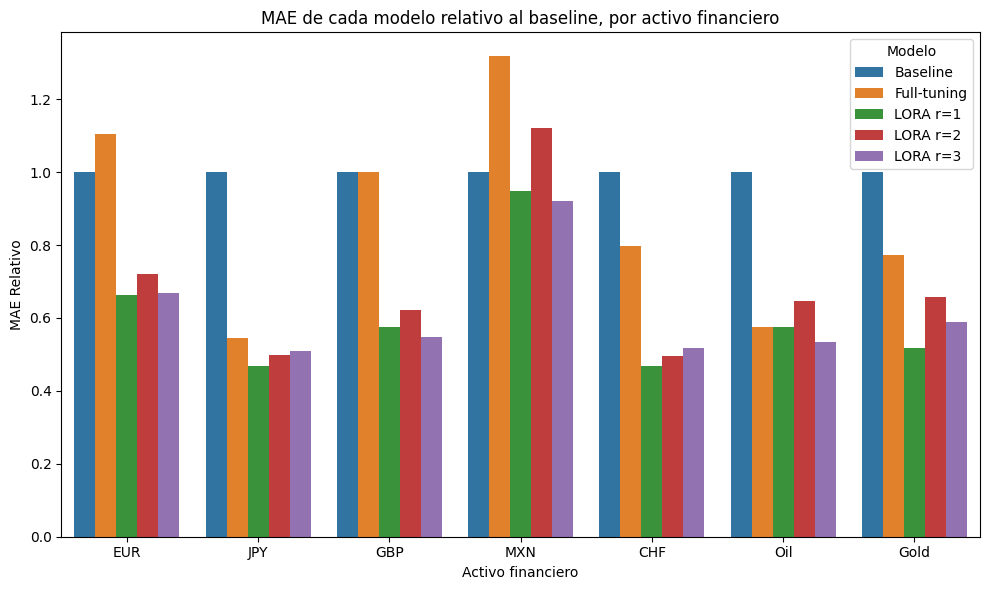

In [28]:
# compute relative MAE
normalized_errors = []
for i in range(len(modelos)):
    normalized_errors.append([mae / mae_raw_baseline[j] for j, mae in enumerate(errores[i])])

errors_dict = {"Modelo": [], "MAE Relativo": [], "Activo financiero": []}
for i in range(len(modelos)):
    errors_dict["Modelo"] = errors_dict["Modelo"] + [modelos[i]] * len(assets)
    errors_dict["MAE Relativo"] = errors_dict["MAE Relativo"] + normalized_errors[i]
    errors_dict["Activo financiero"] = errors_dict["Activo financiero"] + assets

errors_df = pd.DataFrame(errors_dict)

plt.figure(figsize=(10, 6))
sns.barplot(data=errors_df, x="Activo financiero", y="MAE Relativo", hue="Modelo")
plt.title("MAE de cada modelo relativo al baseline, por activo financiero")
plt.ylabel("MAE Relativo")
plt.xlabel("Activo financiero")
plt.tight_layout()
plt.show()

También mostramos una tabla con los errores absolutos medios y en paréntesis el error relativo al baseline como porcentaje.

In [29]:
pd.DataFrame.from_dict(
    {
        model: [f"{mae:.8f} ({100*mae/mae_raw_baseline[j]:.2f}%)" for j, mae in enumerate(errores[i])] for i, model in enumerate(modelos)
    },
    orient="index",
    columns=assets,
)

EUR                   JPY                   GBP  \
Baseline     0.00144945 (100.00%)  0.00001645 (100.00%)  0.00218466 (100.00%)   
Full-tuning  0.00160161 (110.50%)   0.00000895 (54.40%)  0.00218707 (100.11%)   
LORA r=1      0.00096078 (66.29%)   0.00000769 (46.78%)   0.00125555 (57.47%)   
LORA r=2      0.00104353 (72.00%)   0.00000820 (49.85%)   0.00136002 (62.25%)   
LORA r=3      0.00096776 (66.77%)   0.00000840 (51.06%)   0.00119769 (54.82%)   

                              MXN                   CHF                   Oil  \
Baseline     0.00008272 (100.00%)  0.00233714 (100.00%)  0.57703244 (100.00%)   
Full-tuning  0.00010897 (131.74%)   0.00186540 (79.82%)   0.33236163 (57.60%)   
LORA r=1      0.00007842 (94.81%)   0.00109474 (46.84%)   0.33241431 (57.61%)   
LORA r=2     0.00009281 (112.21%)   0.00115586 (49.46%)   0.37226079 (64.51%)   
LORA r=3      0.00007620 (92.12%)   0.00121014 (51.78%)   0.30801401 (53.38%)   

                             Gold  
Baseline     7.03674445 (100.00%)  
Full-tuning   5.43661364 (77.26%)  
LORA r=1      3.64885867 (51.85%)  
LORA r=2      4.61936147 (65.65%)  
LORA r=3      4.15264896 (59.01%)

En la comparación de modelos para el error absoluto medio (MAE) relativo al baseline en diferentes activos financieros, se observa que el modelo con full-tuning generalmente supera al baseline, pues sólo con el peso mexicano (MXN) y el euro (EUR) hay un mayor error (131.74% y 110.50%, respectivamente). En contraste, los modelos con LORA, particularmente con r=1 y r=3, logran reducir el MAE en todos los activos en un aproximado del 60%. Est interesante que en todos los activos salvo hay un modelo LORA que supera al full-tuning. Además, se observa que con una actualización de rango $r=1$ fue suficiente para un buen ajuste. 

Cabe mencionar que el modelo original tenía 2,766,848 parámetros entrenables, y con la estrategia LORA con $r=1$ el número de parámetros entrenables fueron 37,667, el cual es el 1.36% del número de parámetros entrenables del modelo original.

Esto sugiere que, aunque el ajuste completo puede ser efectivo en ciertos contextos, la estrategia LORA ofrece una alternativa más eficiente para hacer fine-tuning de un modelo.